# Статистика

В данном ноутбуке рассмотрены основные методы статистики:

 - Основные определения: проверка гипотез, доверительные интервалы
 - Критерии для среднего
 - Критерии для доли
 - Критерий согласия
 - Проверка на нормальность
 - Корреляции
 - Проблема множественной проверки гипотез
 - A/B тестирование

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Пример

Расмотрим случайную выборку и попробуем что-то сказать про его матожидание

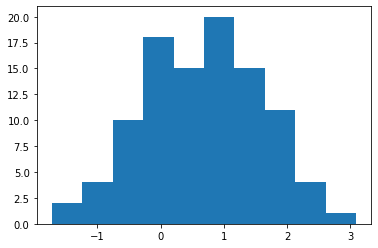

mean: 0.682645621399971


In [80]:
np.random.seed(0)
mu = np.random.random()  # генерируем случайное матожидание
sigma = 1
size = 100
x = np.random.normal(loc=mu, scale=sigma, size=size)  # генерируем выборку
plt.hist(x)
plt.show()
print('mean:', x.mean())

1) У нас есть точечная оценка среднего этой выборки. Однако не очень понятно насколько эта оценка правдоподобно. Хочется получить некоторый интервал так что мы будем уверены что истинное значение находиться в этом интервале

Для решения этих проблем можно воспользоваться центральной предельной теоремой

Пусть $X_{1},\ldots ,X_{n}$  есть бесконечная последовательность независимых одинаково распределённых случайных величин, имеющих конечное математическое ожидание $\mu$  и дисперсию $\sigma ^{2}$, тогда: 

$${\frac {{\bar {X}}_{n}-\mu }{\frac{\sigma}{\sqrt {n}} }}\to N(0,1)$$


Мы знаем распределение $\bar{X_n}∼N(µ, \frac{\sigma^2}{n})$
При этом нам известно что:

$$P(\mu-z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt {n}} \leq \bar{X_n} \leq \mu-z_{1+\frac{\alpha}{2}} \frac{\sigma}{\sqrt {n}}) = 1 -\alpha $$

Можно перегруппировать матожидание и среднее и получается:
$$P(\bar{X_n}-z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt {n}} \leq \mu \leq \bar{X_n}-z_{1+\frac{\alpha}{2}} \frac{\sigma}{\sqrt {n}}) = 1 - \alpha $$

Таким образом можно получиться что с веротяностью $1-\alpha$ истинное значение лежит в промежутке:

$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \dfrac{\sigma}{\sqrt{n}}$


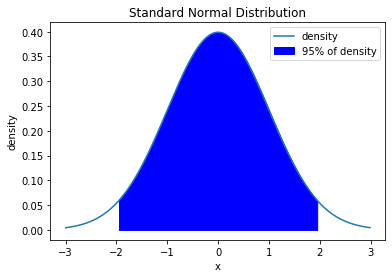

In [81]:
F_H0 = stats.norm(loc=0, scale=1)
data = np.arange(-3,3,0.01)
pdf = F_H0.pdf(data)
plt.plot(data, pdf, label='density')
plt.xlabel('x')
plt.ylabel('density')
left = F_H0.ppf(0.025)
right = F_H0.ppf(0.975)
plt.fill_between(data, pdf, where=(left < data)&(data < right), color='blue', label='95% of density')
plt.title('Standard Normal Distribution')
plt.legend()
plt.show()

In [82]:
# посчитаем доверительный интервал
alpha = 0.05
right = x.mean() + stats.norm.ppf(1 - alpha/2) * (sigma / np.sqrt(size))
left = x.mean() - stats.norm.ppf(1 - alpha/2) * (sigma / np.sqrt(size))
print(f'interval: {np.round(left, 3)}, {np.round(right, 3)}')

interval: 0.487, 0.879


In [83]:
mu

0.5488135039273248

2) Представим себе что у нас есть некоторое предположение что $\bar{x} = 0.3$. Возникает вопрос как это проверить. 

In [84]:
# посчитаем статистику, которая если верна наша гипотеза будет распределена нормально
hypotheses = 0.4
z = (x.mean() - hypotheses) / (sigma / np.sqrt(size))
print('z:', z)

z: 2.8264562139997094


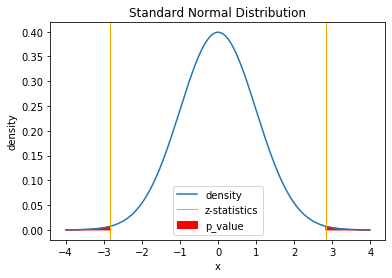

p_value: 0.0023533089099199156


In [85]:
F_H0 = stats.norm(loc=0, scale=1)
data = np.arange(-4,4,0.01)
pdf = F_H0.pdf(data)
plt.plot(data, pdf, label='density')
plt.xlabel('x')
plt.ylabel('density')
# extremely_values
plt.fill_between(data, pdf, where=(z < data)|(-z > data), color='red', label='p_value')
plt.axvline(z, color='orange', linewidth=1, alpha=1, label='z-statistics')
plt.axvline(-z, color='orange', linewidth=1, alpha=1)
plt.title('Standard Normal Distribution')
plt.legend()
plt.show()
p_value = 1-stats.norm.cdf(z)
print('p_value:', p_value)

Как мы видим, маловероятно чтобы матожидание было таким, которое мы задали, поэтому можно сказать что среднее не равно $0.35$

## Общие определения

Допустим что у нас есть некоторая выборка $X^n = (X_1, . . . , X_n), X ∼ P$ , где $P$ неизвестное нам распределение. У нас есть некоторая *гипотеза* $H_0 : P∈ ω$ и у нас есть некоторая *статистика* $T(X_n):T(X_n)∼F(x)$  при $H_0$ , то есть если $H_0$ верна то эта статистика имеет вполне определенное распределение которая называется *нулевым распределением статистики*, альтернативная гипотеза $H_1 : P \not ∈ ω$.  Пара, состоящая из статистики и нулевого распределения, образует *статистический критерий* для проверки нулевой гипотезы против альтернативы

*Достигаемый уровень значимости(p-value)* — это вероятность получить такое же значение статистики, как в эксперименте, или еще более экстремальное, при справедливости нулевой гипотезы. То, какие значения считаются экстремальными, определяется относительно альтернативной гипотезы, то есть, с учетом того, какие значения статистики более вероятны при альтернативе.

<img src="images/an_example_p_value_if_the_alternative_expects_more.png"  width="500px" title="aaa">

Если полученное значение p-value мало, это значит, что данные свидетельствуют против нулевой гипотезы в пользу альтернативной, поскольку вероятность получить такие данные при условии, что нулевая гипотеза справедлива, мала. Обычно p-value сравнивают с порогом $α$, который называется *уровнем значимости*. Чаще всего $α = 0.05$. Если $p ≤ α$, то нулевая гипотеза отвергается в пользу альтернативы. Если $p > α$, то нулевая гипотеза не отвергается.

## Ошибки I и II рода

Ошибки в проверка гипотез не симметричны относительно пары нулевая гипотеза – альтернатива.

<img src="images/type_I_and_II_errors.png"  width="500px" title="aaa">

Ошибка первого рода критичнее, вероятность отвержение нулевой гипотезы в случае, когда она верна, жестко ограничивается. Если нулевая гипотеза отвергается при значении уровня значимости $p ≤ α$, то вероятность ошибки первого рода получается ограниченной сверху:

$P(H_0 ~отвергнута|H_0~ верна)=P(p≤α|H_0) ≤ \alpha$

Таким образом, любой корректный, хорошо построенный критерий имеет вероятность ошибки первого рода не больше, чем $α$.

Что касается ошибки второго рода, то она минимизируется по остаточному принципу. Понятие ошибки второго рода связано с понятием мощности статистического критерия, *мощность* — это вероятность отвергнуть неверную нулевую гипотезу:

$pow = P( отвергаем ~H_0 | H_1 ) = 1 − P(принимаем~ H_0 |_H1 )$ 

Чтобы найти идеальный критерий для проверки пары нулевая гипотеза – альтернатива, нужно среди всех корректных критериев выбрать критерий с максимальной мощностью.

## Статистическая и практическая значимость

*Размер эффекта* - отклонения данных от нулевой гипотезы, определенная на генеральной совокупности. p-value показывает с какой вероятностью такую оценку оценку размера эффекта, какая получена по выборке можно было получить случайно. На практике нам интересно не p-value само по себе, а некоторая практическая ценность

<img src="images/illustration_of_type_I_and_type_II_errors.png"  width="500px" title="aaa">


**Пример**: если мы создаем лекарство, то нам интересно насколько оно увеличивает вероятность выздоровления пациент. И если $H_0$: лекарство не дает никаково эффекта будет отвергнута, но при этом лекарство работает на 1% лучше чем плацебо, но наверное это не имеет какой-то практической ценности.  

**Замечание**: p-value зависит не только от размера эффекта, но и от объема выборки, по которой оценивается эффект. Если выборка небольшая, скорее всего, нулевая гипотеза на ней не отвергается (если только она не слишком дикая). Однако с ростом объема выборки начинают проявляться все более тонкие отклонения данных от нулевой гипотезы. Велика вероятность, что на достаточно большой выборке значительная часть разумных нулевых гипотез будет отвергнута. Именно поэтому, даже если нулевая гипотеза отвергнута, это еще не значит, что полученный эффект имеет какую-то практическую значимость, её нужно оценивать отдельно

## Доверительные интервалы

Часто интерес представляют не только точечные оценки, то и интервальные оценки, то есть доверительные интервалы.  Доверительный интервал для параметра $θ$ задаётся парой статистик $C_L, C_U$, таких что:

$P(C_L ≤θ≤C_U)≥1−α$

где $1 − α$ — это уровень доверия интервала.

Если $\hat{θ}$ — оценка параметра $θ$ и известно её распределение $F_{\hatθ}(x)$, то доверительные пределы можно выразить через квантили этого распределения:

$\mathbb{P}(F^{-1}({\frac{\alpha}{2})} \leq \theta  \leq F^{-1}(1 - {\frac{\alpha}{2}}))=1 - \alpha$

Эти квантили задают доверительный интервал с уровнем доверия $1 − α$

## Связь между проверкой гипотез и доверительными интервалами

Если проверяется точечная нулевая гипотеза против двусторонней альтернативы:

$H_0 : θ = θ_0, H_1 : θ \ne θ_0$

то производить эту проверку можно путём построения доверительного интервала, как было показано выше. Нулевая гипотеза отвергается на уровне значимости $α$, если доверительный интервал для $θ$ с уровнем доверия $1−α$ не содержит $θ_0$.

Также с помощью доверительного интервала можно вычислить достигаемый уровень значимости $p$. Это наибольшее значение $α$, при котором доверительный интервал с уровнем доверия $1−α$ содержит $θ_0$. Таким образом, перебирая разные значения $α$, можно численно найти достигаемый уровень значимости.

Можно наоборот строить доверительные интервалы с помощью критерия, проверяющего гипотезу:

$H_0 : θ = θ_0, H_1 : θ \ne θ_0$

В таком случае доверительный интервал с уровнем доверия $1 − α$ будет состоять из всех значений $θ_0$, для которых такая нулевая гипотеза не отвергается на уровне значимости $α$ против двусторонней альтернативы.

## Замечания:

- Порядок в паре $(H_0, H_1)$  выбирается так, чтобы $H_0$ значила "ничего не происходит", а $H_1$ — "мы сделали важное открытие", потому что с помощью проверки гипотез нельзя доказать справедливость $H_0$: при $p ≤α$ скорее всего, верна $H_1$ а при $p> α$ либо верна $H_0$ либо данных недостаточно
- Часто дают неправильную интерпретацию p-value, например p-value — это просто вероятность справедливости нулевой гипотезы, или вероятность справедливости нулевой гипотезы при условии полученных данных, но это не так! Редкие события тоже происходят
- Если достигаемый уровень значимости p ≤ α, то говорят, что нулевая гипотеза отвергается в пользу альтернативы. Если достигаемый уровень значимости p > α, то нулевая гипотеза не отвергается. Когда гипотеза не отвергается, это значит только то, что нет доказательств того что она неверна. Но отсутствие доказательств не является доказательством ее верности!
- Нужно понимать что пара доверительных интервалов не является восточной для проверки гипотез. Пример: У нас есть 2 классификатора, оцененные на выборке размером 100 и один дает качество 60 % другой 75 %. Мы хотим проверить гипотезу что классификаторы статистически различаются(то есть второй лучше первого), то есть $H_0 : θ_1 = θ_2, H_1 : θ_1 \ne θ_2$. Можно построить доверительные интервалы для каждого из них и получить что они пересекаются, НО из этого не следует что классификаторы статистически неразличимы! Нужно проверять гипотезу(или строить доверительный интервал) на РАЗНИЦУ долей. Если построить доверительный интервал для связный выборок, то получим интервал: [0.06, 0.243] или соответствующее p-value=0.002. То есть гипотеза о неотличимость классификаторов отвергается на любом разумном уровне значимости.
- Некорректно проверять нулевую гипотезу $H_0 : θ_1 = θ_2$ против альтернативы $H_1 : θ_1 < θ_2$ только если мы заранее не знаем что по природе своей не модет быть такого что  $θ_1 > θ_2$. Если мы исходим из этого только из-за средних по выборке, то мы переобучаемся.

# Параметрические критерии: Среднее


## Одновыборочный Z-критерий  Стьюдента

Проверяет  гипотезы о математических ожиданиях нормальных распределений.  При этом считаем что стандартное отклонение известно

<img src="images/description_of_the_z-score.png"  width="500px" title="aaa">

Способ подсчёта достигаемого уровня значимости такого критерия зависит от используемого типа альтер- нативы. Если альтернатива односторонняя $H1 : μ < μ_0$, то, если она справедлива, более вероятными являются маленькие значения Z-статистики, то есть, левый хвост нулевого распределени, значит чтобы посчитать p-value $= F_{N(0,1)} (z)$, аналогично для $H_1 : μ > μ_0$, получается  p-value$= 1 - F_{N(0,1)} (z)$ и для двухсторонней p_value$= 2(1 - F_{N(0,1)} (|z|))$


Пример: Более вероятные значения статистики при использовании альтернативы $H_1 : μ < μ_0$
<img src="images/more_likely_statistic_values_when_using_alternative_H_1.png"  width="500px" title="aaa">

Для z-критерия существует соответствующий доверительный интервал. Для построения z-интервала необходимо знать дисперсию выборки $\sigma^2$ или выдвинуть какое-то предположение о её значении, после этого доверительный интервал примет вид:

$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \dfrac{\sigma}{\sqrt{n}}$

Случаи, когда известна дисперсия, очень редки, на практике её значение практически никогда неизвестно. Пример случая, когда можно использовать z-интервал, — оценка работы некоторого прибора, в таких случаях обычно известна погрешность, а значит, и дисперсия

In [558]:
import numpy as np
from scipy import stats
from sklearn import model_selection, datasets, linear_model, metrics
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

## Пример
Уровень кальция в крови здоровых молодых женщин равен в среднем 9.5 милиграммам на децилитр и имеет характерное стандартное отклонение 0.4 мг/дл. В сельской больнице Гватемалы для 160 здоровых беременных женщин при первом обращении для ведения беременности был измерен уровень кальция; среднее значение составило 9.57 мг/дл. Можно ли утверждать, что средний уровень кальция в этой популяции отличается от 9.5?

Здесь нам известно дисперсия выборки(на генеральной совокупности) поэтому можно использовать Z-критерий стьюденда

In [559]:
z = (9.57 - 9.5) / (0.4 / np.sqrt(160))  # считаем статистику
p_value = 2*(1-stats.norm.cdf(abs(z)))  # вычисляем p-value против двусторонней альтернативы
print('p_value:', p_value)

p_value: 0.026856695507523787


Посчитаем доверительный интервал

In [560]:
alpha = 0.05
right = 9.57 + stats.norm.ppf(1 - alpha/2) * (0.4 / np.sqrt(160))
left = 9.57 - stats.norm.ppf(1 - alpha/2) * (0.4 / np.sqrt(160))
print(f'interval: {np.round(left, 3)}, {np.round(right, 3)}')

interval: 9.508, 9.632


Можно воспользоваться готовой реализацией

In [500]:
# параметр alternative нужен чтобы заменять одно из значений на np.inf
_zconfint_generic(9.57,  0.4 / np.sqrt(160),  0.05, alternative='two-sided')

(9.508020496769545, 9.631979503230456)

При этом это отличие кажется не значимым, так как разница сильно меньше дисперсии. Хотя конечно стоит обратиться к помощи специалиста

## Задача
Ежегодно более 200000 людей по всему миру сдают стандартизированный экзамен GMAT при поступлении на программы MBA. Средний результат составляет $525$ баллов, стандартное отклонение — $100$ баллов. 

Сто студентов закончили специальные подготовительные курсы и сдали экзамен. Средний полученный ими балл — $541.4$. Проверьте гипотезу о неэффективности программы против односторонней альтернативы о том, что программа работает.

In [104]:
z = (541.4 - 525) / (100 / np.sqrt(100))  # считаем статистику
p_value = 1-stats.norm.cdf(abs(z))  # вычисляем p-value против односторонней альтернативы
print('p_value:', p_value)

p_value: 0.05050258347410397


При этом если средний балл будет 541.5, то есть на 0.1 балл выше

In [106]:
z = (541.5 - 525) / (100 / np.sqrt(100))  # считаем статистику
p_value = 1-stats.norm.cdf(abs(z))  # вычисляем p-value против односторонней альтернативы
print('p_value:', p_value)

p_value: 0.0494714680336481


Всегда нужно смотреть на эффект!

## Одновыборочный  t-критерий Стьюдента

Если дисперсия выборки неизвестна, вместо Z-критерия Стьюдента нужно применять t-критерий Стьюдента

<img src="images/description_of_the_t-test.png"  width="500px" title="aaa">


Такая статистика имеет уже не стандартное нормальное нулевое распределение, а распределение Стьюдента с числом степеней свободы n−1. Остальное аналогично

__Замечание__: чем больше выборка тем меньше разница между t и z критериями

Аналогично Z-критерию, доверительный интервал имеет вид:

$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \dfrac{S}{\sqrt{n}}$

где $t_{1-\frac{\alpha}{2}}$ это квантильно распределения Стьюдента, а $S^2$ - выборочная дисперсия по выборке


## Задача

У нас есть 2 классификаторы и мы хотим понять какой из них лучше

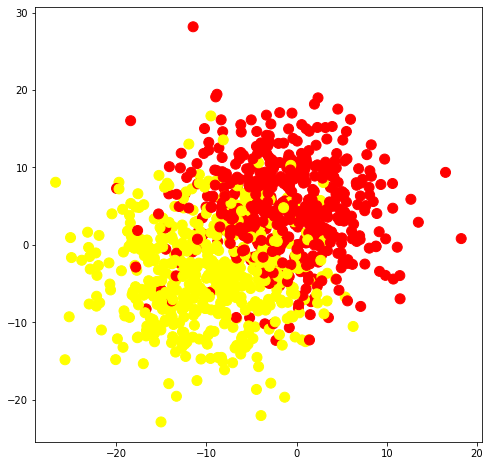

In [561]:
# сгенерируем набор данных
blobs = datasets.make_blobs(1000, centers = 2, cluster_std = 6, random_state=1)
plt.figure(figsize(8, 8))
plt.scatter(list(map(lambda x: x[0], blobs[0])), list(map(lambda x: x[1], blobs[0])), c = blobs[1], cmap = 'autumn',
             s=100)

In [562]:
# посчитаем качество на кросс-валидации
sgd_auc_scores = model_selection.cross_val_score(linear_model.SGDClassifier(max_iter = 1000), 
                                 blobs[0], blobs[1], scoring = 'roc_auc', cv = 20)
ridge_auc_scores = model_selection.cross_val_score(linear_model.RidgeClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)
sgd_mean = sgd_auc_scores.mean()
ridge_mean = ridge_auc_scores.mean()
print("sgd model auc: mean %.3f, std %.3f" % (sgd_mean, sgd_auc_scores.std(ddof=1)))
print("ridge model auc: mean %.3f, std %.3f" % (ridge_mean, ridge_auc_scores.std(ddof=1)))

sgd model auc: mean 0.866, std 0.070
ridge model auc: mean 0.917, std 0.040


__z-интервал__

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [563]:
print("sgd model mean auc 95%% confidence interval", _zconfint_generic(sgd_mean, 
                                                                  sqrt(0.25/len(sgd_auc_scores)), 
                                                                  0.05, 'two-sided'))

print("ridge model mean auc 95%% confidence interval", _zconfint_generic(ridge_mean, 
                                                                    sqrt(0.25/len(sgd_auc_scores)), 
                                                                    0.05, 'two-sided'))

sgd model mean auc 95%% confidence interval (0.6467093648558546, 1.0849706351441455)
ridge model mean auc 95%% confidence interval (0.6981493648558545, 1.1364106351441452)


__t-интервал__

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [566]:
sgd_mean_std = sgd_auc_scores.std(ddof=1)/sqrt(len(sgd_auc_scores))
ridge_mean_std = ridge_auc_scores.std(ddof=1)/sqrt(len(ridge_auc_scores))

In [567]:
print("sgd model mean auc 95%% confidence interval", _tconfint_generic(sgd_mean, sgd_mean_std,
                                                                       len(sgd_auc_scores) - 1,
                                                                       0.05, 'two-sided'))

print("ridge model mean auc 95%% confidence interval", _tconfint_generic(ridge_mean, ridge_mean_std,
                                                                         len(sgd_auc_scores) - 1,
                                                                         0.05, 'two-sided'))

sgd model mean auc 95%% confidence interval (0.8332047367410997, 0.8984752632589004)
ridge model mean auc 95%% confidence interval (0.8985837171373037, 0.9359762828626961)


## Задача №2

Для 61 большого города в Англии и Уэльсе известны средняя годовая смертность на 100000 населения (по данным 1958–1964) и концентрация кальция в питьевой воде (в частях на миллион). Чем выше концентрация кальция, тем жёстче вода. Города дополнительно поделены на северные и южные.

Нужно построить доверительные интервалы для средней смертности в городах и понять еслить ли связь с жесткостью воды

In [989]:
water = pd.read_csv('./data/water.txt', sep='\t')
water.head()

,location,town,mortality,hardness
0,South,Bath,1247,105
1,North,Birkenhead,1668,17
2,South,Birmingham,1466,5
3,North,Blackburn,1800,14
4,North,Blackpool,1609,18


Визуализируем данные

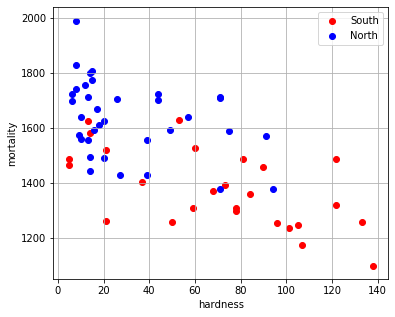

In [994]:
south_mortality = water[water['location'] == 'South']['mortality'].values
north_mortality = water[water['location'] == 'North']['mortality'].values
south_hardness = water[water['location'] == 'South']['hardness'].values
north_hardness = water[water['location'] == 'North']['hardness'].values
plt.figure(figsize=(6, 5))
plt.scatter(south_hardness, south_mortality, label='South', color='red')
plt.scatter(north_hardness, north_mortality, label='North', color='blue')
plt.xlabel('hardness')
plt.ylabel('mortality')
plt.grid()
plt.legend()
plt.show()

In [1007]:
# построим довериельные интревал для средней смертности в городах
left, right = _tconfint_generic(water['mortality'].mean(),
                  water['mortality'].std(ddof=1) / np.sqrt(len(water)),
                  len(water) - 1, 0.05, 'two-sided')
print(f'mortality interval [{np.round(left, 3)}, {np.round(right, 3)}] '\
      'width {np.round(interval[1] - interval[0], 3)}')

mortality interval [1476.083, 1572.212] width {np.round(interval[1] - interval[0], 3)}


In [ ]:
# построим доверительные интревалы для средней сметрности в южных и северных городах
left, right = _tconfint_generic(south_mortality.mean(),
                  south_mortality.std(ddof=1) / np.sqrt(len(south_mortality)),
                  dof=len(south_mortality) - 1,
                  alpha=0.05,
                  alternative='two-sided')
print('south mortality:')
print(f'interval [{np.round(left, 3)}, {np.round(right, 3)}] with width {np.round(interval[1] - interval[0], 3)}')

left, right = _tconfint_generic(north_mortality.mean(),
                  north_mortality.std(ddof=1) / np.sqrt(len(north_mortality)),
                  dof=len(north_mortality) - 1,
                  alpha=0.05,
                  alternative='two-sided')
print('north mortality:')
print(f'interval [{np.round(left, 3)}, {np.round(right, 3)}] with width {np.round(interval[1] - interval[0], 3)}')

Интервалы не пересекаются; видимо, средняя смертность на севере и на юге существенно разная. Но нужно явно проврить эту гипотизу!  

In [1011]:
# построим доверительные интревалы для средней жесткости воды в южных и северных городах
left, right = _tconfint_generic(south_hardness.mean(),
                  south_hardness.std(ddof=1) / np.sqrt(len(south_hardness)),
                  dof=len(south_hardness) - 1,
                  alpha=0.05,
                  alternative='two-sided')
print('south hardness:')
print(f'interval [{np.round(left, 3)}, {np.round(right, 3)}] with width {np.round(interval[1] - interval[0], 3)}')

left, right = _tconfint_generic(north_hardness.mean(),
                  north_hardness.std(ddof=1) / np.sqrt(len(north_hardness)),
                  dof=len(north_hardness) - 1,
                  alpha=0.05,
                  alternative='two-sided')
print('north hardness:')
print(f'interval [{np.round(left, 3)}, {np.round(right, 3)}] with width {np.round(interval[1] - interval[0], 3)}')

south hardness:
interval [53.467, 86.071] with width 96.128
north hardness:
interval [21.422, 39.378] with width 96.128


## Двухвыборочный Z-критерий Стьюдента, независимые выборки

Если имеются две выборки из нормального распределения с различными параметрами, дисперсии для которых известны, то используется Z-критерий. Статистика этого критерия имеет стандартное нормальное распределение


<img src="images/description_of_the_two-sample_Z-test.png"  width="500px" title="aaa">

## Двухвыборочный t-критерий Стьюдента, независимые выборки

Если дисперсии выборок неизвестны, то можно воспользоваться t- критерием Стьюдента. При выполнении нулевой гипотезы она будет распределена по Стьюденту.

<img src="images/description_of_the_two-sample_t-test.png"  width="500px" title="aaa">

При этом количество степеней свободы свободы вычисляется по страшной формуле:

$ν=\dfrac{(\frac{S_1^2}{n_1} +\frac{S_2^2}{n_2} )^2}{\frac{S_1^4}{n_1^2(n_1-1)} + \frac{S_2^4}{n_2^2(n_2-1)}}$

При этом нужно иметь ввиду что нулевое распределение t-статистики не точное, а приближенное. Эта проблема называется *проблемой Беренца- Фишера*: невозможно точно сравнить средние значение в двух выборках, дисперсии которых неизвестны.

Однако рассмотренная аппроксимация достаточно точна в двух ситуациях. Во-первых, если выборки $X_1$ и $X_2$ одинакового объема, то есть $n_1 = n_2$. Во-вторых, если знак неравенства между $n_1$ и $n_2$ такой же, как между $σ_1$ и $σ_2$, то есть выборка с большей дисперсией по размеру не может быть меньше другой выборки. Если это не так, то возникает проблема: критерий Стьюдента перестает правильно работать, и вероятность ошибок первого рода начинает превышать уровень значимости $α$.


## t-критерий Стьюдента для связанных выборок

Для проверки равенства математических ожиданий двух выборок одинакового объёма из нормальных распределений используется t-критерий Стьюдента

<img src="images/description_of_students_t-test_for_related_samples.png"  width="500px" title="aaa">

В числителе T-статистики стоит разность $\overline{X_1} − \overline{X_2}$. Это то же самое, что $\overline{X1 − X2}$. Таким образом, t-критерий для двух связанных выборок эквивалентен одновыборочному t-критерию, примененному к выборке попарных разностей.

Чтобы построить доверительный интервал, для разницы, нужно только взять выборку $X_1 - X_2 $и посчитать интервал для нее

## Задача

Имеются данные о стоимости и размерах 53940 бриллиантов. Определим какой классификатор __LinearRegression__ или __RandomForestRegressor__ дает лучшее качество

In [568]:
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [569]:
diamonds = pd.read_csv('./data/diamonds.txt', sep='\t')
diamonds.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [571]:
# разделим выборку на обучение и тест
train_data, test_data = train_test_split(diamonds, test_size=0.25, random_state=1)
y_train = train_data['price']
X_train = train_data.drop(['price'],axis=1)
y_test = test_data['price']
X_test = test_data.drop(['price'],axis=1)

# обучим 2 классификатора
linear_regression = LinearRegression()
random_forest_regressor = RandomForestRegressor(10, random_state=1)
linear_regression.fit(X_train, y_train)
random_forest_regressor.fit(X_train, y_train)

# посчитаем ошибку на каждом примере
y_pred = linear_regression.predict(X_test)
mae_linear = np.abs(y_pred - y_test)
y_pred = random_forest_regressor.predict(X_test)
mae_random_forest = np.abs(y_pred - y_test)

In [572]:
# выпишем среднюю ошибку
print(mae_linear.mean(), mae_random_forest.mean())

890.3764004285566 802.9205172724141


Так как выборки связаны, то можно воспольвозаться критерием Стьюденда для связных выборок

In [573]:
statistic, p_value = stats.ttest_rel(mae_linear, mae_random_forest)
print('p_value:', p_value)

p_value: 1.655174575144972e-38


Как видим гипозеза о том что средняя ошибка одинаковая для обоих классификаторов отвергается на любом уровне значимости. Поэтому можно утверждать что для этой задачи RandomForest работает лучше чем линейная регрессия.

Посчитаем доверитльный интервал для разности

In [574]:
print("95%% confidence interval: [%f, %f]" % DescrStatsW(mae_linear - mae_random_forest).tconfint_mean())

95% confidence interval: [74.287245, 100.624521]


# Параметрические критерии: Доли

В случаях когда ведётся работа с генеральной совокупностью, состоящей из бинарных событий. Возникает потребность проверки гипотез и построении доверительных интервалов о доле.

## Z-критерий для доли

Если у нас есть выборка из распределения Бернулли и мы хотим проверить гипотезу о параметре p, то можно воспользоваться Z-критерий для доли

<img src="images/description_of_the_z-score_for_proportion.png"  width="500px" title="aaa">


Этому критерию соответствует доверительный интервал Вальда. Формула для такого интервала:

$\hat{p} \pm z_{1-\frac{\alpha}{2}} \dfrac{\sqrt{\hat{p}(1 - \hat{p})}}{n}$

Основан на основе нормального распределения с использованием центральной предельной теоремы. У накатного метода построения доверительных интервалов есть существенные недостатки

- доверительные пределы могут выходить за границы $[0, 1]$
- при $\hat{p} =0$ и $\hat{p} = 1$ вырождается в точку

## Точный(Биномиальный) критерий для доли

<img src="images/description_of_exact_criteria_for_share.png"  width="500px" title="aaa">

Поскольку нулевое распределение дискретно, нельзя добиться, чтобы вероятность ошибки первого рода была равна в точности $α$. Критерий консервативен — истинная вероятность ошибки первого рода ограничена уровнем значимости сверху.


In [575]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats import proportion
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import samplesize_confint_proportion

## Пример 

Джеймс Бонд говорит, что предпочитает мартини взболтанным, но не смешанным. Проведём слепой тест (blind test): $n$ раз предложим ему пару напитков и выясним, какой из двух он предпочитает. Получаем: 
* **выборка:** бинарный вектор длины $n$, где 1 — Джеймс Бонд предпочел взболтанный напиток, 0 — смешанный;
* **гипотеза $H_0$:** Джеймс Бонд не различает 2 вида напитков и выбирает наугад;
* **статистика $T$:** количество единиц в выборке.

Если нулевая гипотеза справедлива и Джеймс Бонд действительно выбирает наугад, то мы можем с одинаковой вероятностью получить любой из $2^n$ бинарных векторов длины $n$. 

Мы могли бы перебрать все такие векторы, посчитать на каждом значение статистики $T$ и получить таким образом её нулевое распределение. Но в данном случае этот этап можно пропустить: мы имеем дело с выборкой, состоящей из 0 и 1, то есть, из распределения Бернулли $Ber(p)$. Нулевая гипотеза выбора наугад соответствует значению $p=\frac1{2}$, то есть, в каждом эксперименте вероятность выбора взболтанного мартини равна $\frac1{2}$. Сумма $n$ одинаково распределённых бернуллиевских случайных величин с параметром $p$ имеет биномиальное распределение $Bin(n, p)$. Следовательно, нулевое распределение статистики $T$ — $Bin\left(n, \frac1{2}\right)$.

Пусть $n=16.$

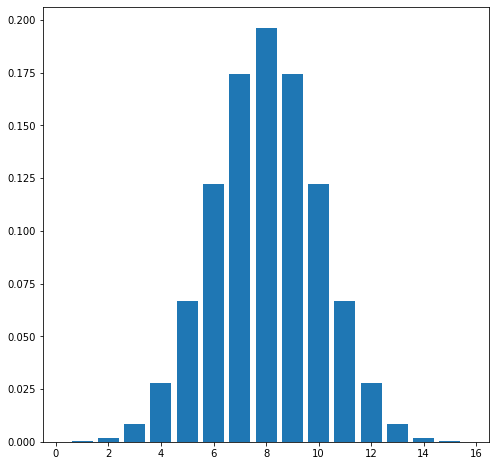

In [577]:
n = 16
F_H0 = stats.binom(n, 0.5)
x = np.linspace(0,16,17)

plt.bar(x, F_H0.pmf(x), align = 'center')
plt.xlim(-0.5, 16.5) 
plt.show()

## Односторонняя альтернатива

**гипотеза $H_1$:** Джеймс Бонд предпочитает взболтанный мартини.

При такой альтернативе более вероятны большие значения статистики; при расчёте достигаемого уровня значимости будем суммировать высоту столбиков в правом хвосте распределения.

Предположим что Джейсм Бонд угадал напиток 12 раз


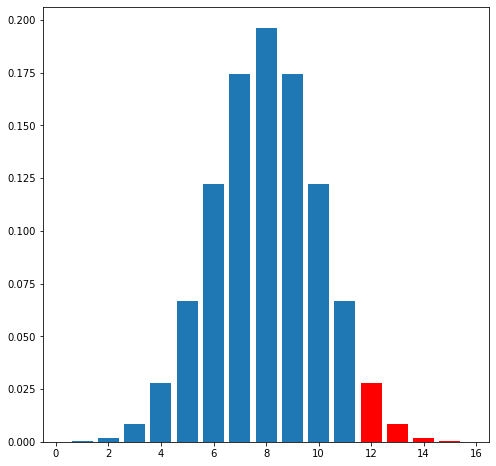

In [578]:
plt.bar(x, F_H0.pmf(x), align = 'center')
plt.bar(np.linspace(12,16,5), F_H0.pmf(np.linspace(12,16,5)), align = 'center', color='red')
plt.xlim(-0.5, 16.5) 
plt.show()

Чтобы это проверить можно поспользоваться точным биноминальным тестом

In [580]:
p_value = stats.binom_test(12, 16, 0.5, alternative='greater')
print('p_value:', p_value)
# альтернатива
# proportion.binom_test(12, 16, 0.5,  alternative='larger')

p_value: 0.0384063720703125


In [581]:
# Можно воспользоваться Z-критерием
# Замечание: нужно подать отдельно вероятность по которой считается знаменатель статистики: prop_var
# подробнее см https://stats.stackexchange.com/questions/447462/why-does-the-proportions-ztest-function-in-statsmodels-produce-different-values
statistic, p_value = proportion.proportions_ztest(12, 16, 0.5, alternative='larger', prop_var=0.5)
print('p_value:', p_value)

p_value: 0.022750131948179195


## Пример

In [582]:
# сгенерируем выборку генеральной совокупности
np.random.seed(1)
statistical_population = np.random.randint(2, size = 100000) 
# рассмотрим небольшую подвыборку
random_sample = np.random.choice(statistical_population, size = 1000)
#истинное значение доли
print(f"general mean: {statistical_population.mean()}")
# среднее на подвыборке
print(f"general mean: {random_sample.mean()}")

general mean: 0.49771
general mean: 0.502


__Доверительный интервал на основе нормального распределения__

$$\hat{p}\pm z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}$$

In [583]:
normal_interval = proportion_confint(sum(random_sample), len(random_sample), method = 'normal')
print('normal_interval [%f, %f] with width %f' % (normal_interval[0],
                                                  normal_interval[1], 
                                                  normal_interval[1] - normal_interval[0]))

normal_interval [0.471010, 0.532990] with width 0.061979


__Доверительный интервал Уилсона__

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{
z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [584]:
wilson_interval = proportion_confint(sum(random_sample), len(random_sample), method = 'wilson')
print('wilson_interval [%f, %f] with width %f' % (wilson_interval[0],
                                                  wilson_interval[1],
                                                  wilson_interval[1] - wilson_interval[0]))

wilson_interval [0.471062, 0.532922] with width 0.061860


__Размер выборки для интервала заданной ширины__

Расчитаем размер выбоки чтобы получить доверительный интервал заданной ширины. Замечание: нужно не забыть округлять количество примеров в большую сторону!

In [585]:
n_samples = int(np.ceil(samplesize_confint_proportion(random_sample.mean(), 0.01)))
print('n_samples:', n_samples)

n_samples: 9604


In [586]:
# Проверим это
np.random.seed(1)
random_sample = np.random.choice(statistical_population, size = n_samples)
normal_interval = proportion_confint(sum(random_sample), len(random_sample), method = 'normal')

print('normal_interval [%f, %f] with width %f' % (normal_interval[0],
                                                  normal_interval[1],
                                                  normal_interval[1] - normal_interval[0]))

normal_interval [0.481776, 0.501773] with width 0.019997


Получили тот результат что и ожидали!

## Z-критерий для доли для двух независимых выборок

Если у нас есть 2 независимые выборки и мы хотим проверить гипотезу о параметрах p этих выборках, то можно воспользоваться Z-критерием

<img src="images/description_of_the_z-test_for_proportion_for_two_independent_samples.png"  width="500px" title="aaa">

При этом чтобы вычислить параметры $\hat{p_1}$ и $\hat{p_2}$ нужно воспользоваться таблицей сопряженности

  | | $X_1$ | $X_2$  
  ------------- | -------------| -------------| 
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
 
После этого можно оценить оценки параметров $p$ для каждой выборки:  $ \hat{p}_1 = \frac{a}{n_1}$ $ \hat{p}_2 = \frac{b}{n_2}$


Доверительный интервал для разности долей $p_1 - p_2$:
$$\hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

## Z-критерий для доли для двух связанных выборок

В случае если выборки связные, то можно улучшить предыдущий метод

<img src="images/description_of_the_Z-test_for_proportion_for_related_samples.png"  width="500px" title="aaa">

В этом случае таблица сопряженности будет иметь вид:

|$X_1$ \ $X_2$ | 1| 0 | $x$|
  ------------- | -------------| -------------| -------------|
  1  | e | f | e + f
  0  | g | h | g + h
  $\sum$ | e + g| f + h | n 

После этого можно оценить оценки параметров $p$ для каждой выборки: $ \hat{p}_1 = \frac{e + f}{n}$ $ \hat{p}_2 = \frac{e + g}{n}$


Доверительный интервал для разности долей $p_1 - p_2$:
$$\frac{f - g}{n} \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{f + g}{n^2} - \frac{(f - g)^2}{n^3}}$$


## Доверительный интервал Уилсона

Этот метод является некоторым улучшением z метода, которое позволяет получать качественные оценки в крайних случаях (то есть когда доля близка к 0 или 1). Формула для расчета:

$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{
z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$

## Задача

В одном из выпусков программы "Разрушители легенд" проверялось, действительно ли заразительна зевота. В эксперименте участвовало 50 испытуемых, проходивших собеседование на программу. Каждый из них разговаривал с рекрутером; в конце 34 из 50 бесед рекрутер зевал. Затем испытуемых просили подождать решения рекрутера в соседней пустой комнате. 

Во время ожидания 10 из 34 испытуемых экспериментальной группы и 4 из 16 испытуемых контрольной начали зевать. Таким образом, разница в доле зевающих людей в этих двух группах составила примерно 4.4%. Ведущие заключили, что миф о заразительности зевоты подтверждён. 

Можно ли утверждать, что доли зевающих в контрольной и экспериментальной группах отличаются статистически значимо? Посчитайте достигаемый уровень значимости при альтернативе заразительности зевоты, округлите до четырёх знаков после десятичной точки.

In [77]:
count1 = 10
nobs1 = 34
count2 = 4
nobs2 = 16

p_1 = count1 / nobs1
p_2 = count2 / nobs2
p = (count1 + count2) / (nobs1 + nobs2)
statistic = (p_1 - p_2) / np.sqrt((p * (1 - p) * (1 / nobs1 + 1 / nobs2)))
p_value = (1 - stats.norm.cdf(statistic))
print('statistic: ', np.round(statistic, 4), 'p_value:', p_value)

statistic:  0.3241 p_value: 0.37293045872523534


In [81]:
# можно воспользоваться готовой функцией
p_value = proportion.test_proportions_2indep(count1, nobs1, count2, nobs2, method='wald', alternative='larger').pvalue
print('p_value:', p_value)

p_value: 0.37053233101234234


## Задача


Предположим себе ситуацию что у нас есть 2 баннера. Мы хотим определить какой из них более превлекательныйи. Для этого мы показывали их людям и попросили их поставить like если какой-то баннер им понравился

In [13]:
banner_click = pd.read_csv('banner_click_stat.txt', header = None, sep = '\t')
banner_click.columns = ['banner_a', 'banner_b']
banner_click.head()

,banner_a,banner_b
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0


In [14]:
conf_interval_banner_a = proportion_confint(sum(banner_click.banner_a), 
                                            banner_click.shape[0],
                                            method = 'wilson')
conf_interval_banner_b = proportion_confint(sum(banner_click.banner_b), 
                                            banner_click.shape[0],
                                            method = 'wilson')
print('interval for banner a [%f, %f]' % conf_interval_banner_a)
print('interval for banner b [%f, %f]' % conf_interval_banner_b)

interval for banner a [0.026961, 0.050582]
interval for banner b [0.040747, 0.068675]


In [28]:
left, right = proportion.confint_proportions_2indep(banner_click.banner_a.sum(),
                                      len(banner_click.banner_a),
                                      banner_click.banner_b.sum(), 
                                      len(banner_click.banner_b), method='wald')
print("x mean 95%% confidence interval", np.round([left, right], 3))

x mean 95%% confidence interval [-0.034  0.002]


Однако выборки зависимы! Можно этим воспользоваться

In [79]:
# для связных выборок нет готовой реализации
def proportions_confint_diff_rel(sample1, sample2, alpha = 0.05):
    z = stats.norm.ppf(1 - alpha / 2.)
    sample = list(zip(sample1, sample2))
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

In [80]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_rel(banner_click.banner_a, banner_click.banner_b))

confidence interval: [-0.026689, -0.005311]


Мы выдим что доверительный интервал полностью лежит в отрицательной плоскости, значит что второй баннер лучше первого

## Задача

Имеются данные измерений двухсот швейцарских тысячефранковых банкнот, бывших в обращении в первой половине XX века. Сто из банкнот были настоящими, и сто — поддельными. На рисунке ниже показаны измеренные признаки:

<img src="images/franc.jpeg"  width="500px" title="aaa">

Проверьте 2 классификатора:
- логистическая регрессия по признакам $X_1,X_2,X_3$
- логистическая регрессия по признакам $X_4,X_5,X_6$

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [117]:
banknotes = pd.read_csv('./data/banknotes.txt', sep='\t')
banknotes.head()

,X1,X2,X3,X4,X5,X6,real
0,214.8,131.0,131.1,9.0,9.7,141.0,1
1,214.6,129.7,129.7,8.1,9.5,141.7,1
2,214.8,129.7,129.7,8.7,9.6,142.2,1
3,214.8,129.7,129.6,7.5,10.4,142.0,1
4,215.0,129.6,129.7,10.4,7.7,141.8,1


In [177]:
train_data, test_data = train_test_split(banknotes, test_size=0.25, random_state=0)

In [178]:
clf_logreg_1 = LogisticRegression()
clf_logreg_1.fit(train_data[['X1', 'X2', 'X3']].values, train_data['real'].values)
pred_1 = clf_logreg_1.predict(test_data[['X1', 'X2', 'X3']].values)
accuracy_1 = np.array(pred_1 == test_data['real']).astype(int)
print('accuracy_1', np.round(accuracy_1.mean(), 4))

clf_logreg_2 = LogisticRegression()
clf_logreg_2.fit(train_data[['X4', 'X5', 'X6']].values, train_data['real'].values)
pred_2 = clf_logreg_2.predict(test_data[['X4', 'X5', 'X6']].values)
accuracy_2 = np.array(pred_2 == test_data['real']).astype(int)
print('accuracy_2', np.round(accuracy_2.mean(), 4))

accuracy_1 0.9
accuracy_2 1.0


Проверим гипотизу что классификаторы равны по качеству

In [179]:
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

In [180]:
z_stat = proportions_diff_z_stat_rel(accuracy_1, accuracy_2)
p_value = 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
print('p_value:', p_value)

p_value: 0.018422125454099048


Посчитаем доверительный интервал

In [181]:
proportions_confint_diff_rel(accuracy_2, accuracy_1)

(0.016845770539019325, 0.1831542294609807)

# Критерий согласия

Иногда встречаются задачи когда нужно определить, а подчиняется ли выборка определенному распределению. Для проверки таких гипотез используются критерии согласия.

*Критерии согласия* - это критерии проверки гипотез о соответствии эмпирического распределения теоретическому распределению вероятностей.

**Критерия согласия Пирсона(критерий хи-квадрат)**

Критерия согласия Пирсона является наиболее часто употребляемым критерием для проверки гипотезы о принадлежности наблюдаемой выборки $x_1, x_2, ..., x_n$ объёмом $n$ некоторому теоретическому закону распределения $F(x, \theta)$.

Статистика критерия конструируется следующим образом: область изменения случайной величины разбивается на $K$ интервалов (карманов). Границы этих интервалов задаются величинами ai. Для каждого интервала $[a_i,a_{i+1}]$ вычисляются две величины. Во-первых, $n_i$ — число элементов выборки, которое попало в интервал. Во-вторых, $p_i$ — теоретическая вероятность попадания в этот интервал при условии справедливости нулевой гипотезы, то есть $P_{i}(\theta )=F(x_{(i)},\theta )-F(x_{(i-1)},\theta )$.

Значение статистики выглядит следующим образом

$\chi^2(X_n)=\sum_{i=1}^K\dfrac{(n_i - np_i)^2}{np_i}$

Если нулевая гипотеза справедлива, то такая статистика имеет распределение хи-квадрат с 
$r=k-m-1$ степенями свободы, где $m$ — количество оценённых по выборке параметров.

Чтобы вычислить достигаемый уровень значимости, необходимо взять интеграл от распределения хи- квадрат, начиная от значения статистики, которое реализуется в данных, до бесконечности.

<img src="images/chi-square_distribution.png"  width="500px" title="aaa">

Критерий хи-квадрат обладает несколькими очевидными недостатками. Во-первых, разбиение на интервалы в нём никак не зафиксировано, и, выбирая различные интервалы, можно получать разные результаты. Кроме того, для того, чтобы его использовать, необходимо иметь достаточно большую выборку

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

# Задача

Для участка заповедника размером 200х200 м имеется информация о координатах сосен (sn — координата в направлении север-юг, we — в направлении запад-восток, обе от 0 до 200).

Нулевая гипотеза: деревья растут равномерно

In [64]:
pines = pd.read_csv('./data/pines.txt', sep='\t')
pines.head()

,sn,we
0,200.0,8.8
1,199.3,10.0
2,193.6,22.4
3,167.7,35.6
4,183.9,45.4


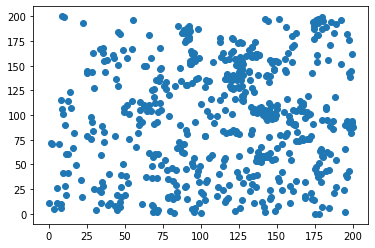

In [65]:
# Отриусем сосны на графике
plt.scatter(pines['we'], pines['sn'])
plt.show()

Для того чтобы проверить эту гипотезу разобьем участок на блоки 40 на 40 и для каждого посчитаем количество деревьев. Если гипотеза верна, то распределение деревьев будет равномерным

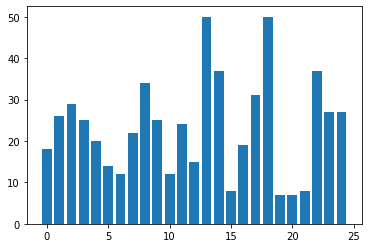

In [66]:
bin_x = list(range(0, 201, 40))
bin_y = list(range(0, 201, 40))
distribution = stats.binned_statistic_2d(pines.sn.values, pines.we.values, None, 'count', bins=[bin_x, bin_y])
distribution = distribution.statistic# / np.sum(distribution.statistic)
distribution = distribution.reshape(-1)
plt.bar(range(25), distribution)
plt.show()

Как видим распределние совсем не похоже на равноммерное. Для того чтобы показать это статистически можно воспользоваться критерием хи-квадрат(критерий согласованности Пирсона)

In [67]:
# сгенерируем нулевое распределение
n_pines = np.sum(distribution)
n_bins = len(distribution)
expected_distribution = np.ones_like(distribution) * n_pines / n_bins  # равномерное распределение
# у нас нет параметров распределения котоорые мы бы оценивали, поэтому ddof = 0
chisquare_stats, p_value = stats.chisquare(distribution, expected_distribution, ddof=0)
print('p_value:', p_value)

p_value: 2.574669774967279e-20


Гипотеза отвергается на любом разумном уровне значимости

## Задача №2

Исчерпанная рождаемость — количество детей, родившихся у женщины на момент окончания конвенционального репродуктивного возраста (45 лет). Для 1878 женщин старше 45, участвовавших в социологическом опросе жителей Швейцарии, известно количество детей. Этот признак — типичный счётчик, а, значит, его можно попробовать описать распределением Пуассона.

* **выборка** - целочисленный вектор длиы $n$, характеризующий количество детей у опрашиваемой женщины
* **гипотеза $H_0$** - рассматриваемая величина имеет распределение Пуассона

In [68]:
childbirth = open('./data/childbirth.txt', 'r')
childbirth = list(map(lambda x: int(x.strip()), childbirth.readlines()))

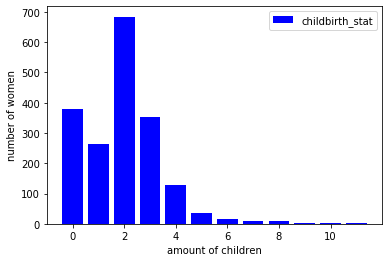

In [69]:
observed_frequences = np.bincount(childbirth)
plt.bar(range(np.max(childbirth) + 1), observed_frequences, color = 'b', label = 'childbirth_stat')
plt.xlabel('amount of children')
plt.ylabel('number of women')
plt.legend()
plt.show()

Распределение пуассона имеет вид

$p(k)\equiv \mathbb {P} (Y=k)={\frac {\lambda ^{k}}{k!}}\,e^{-\lambda }$

Оно имеет параметра $\lambda$, лучше оценком $\lambda$ является среднее по выбоке

l: 1.93716719914803


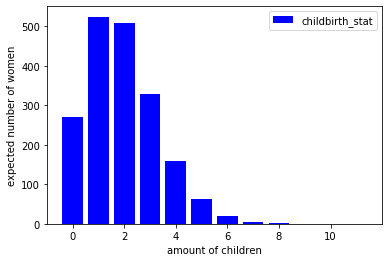

In [70]:
l = np.mean(childbirth)
print('l:', l)
expected_frequences = [len(childbirth)*stats.poisson.pmf(x, l) for x in range(min(childbirth), max(childbirth) + 1)]
expected_frequences = np.array(expected_frequences)
plt.bar(range(np.max(childbirth) + 1), expected_frequences, color = 'b', label = 'childbirth_stat')
plt.xlabel('amount of children')
plt.ylabel('expected number of women')
plt.legend()
plt.show()

__Замечаине__: при подсчете может статистик может произойти ошибка в вычислениях, так что сумма ожидаемых налюдений будет на некоторую дельту отличаться от реальных количества наблюдений. Поэтому лучше это проверить, так как функция __stats.chisquare__ проверяет равернство!

In [71]:
calculation_error = expected_frequences.sum() - observed_frequences.sum()
assert calculation_error < 1e-7
expected_frequences[0] -= calculation_error

In [72]:
statistic, p_value = stats.chisquare(observed_frequences, expected_frequences, ddof = 1)
print('p_value:', p_value)

p_value: 1.774160789512865e-86


Гипотеза отверкается на любом разумном уровне значимости

# Нормальность выборки

Для многих критериев, в частности для критерия стьюдента есть предположение что выборки взяты из нормального распределения. Следовательно нужно уметь проверять выборку на нормальность.

## Критерия согласия Пирсона(критерий хи-квадрат)

Нормальность можно проверять с помощью критерия согласия Пирсона, или критерия хи-квадрат.  для гипотезы о нормальности критерий будет иметь следующий вид:

<img src="images/description_of_the_chi-square_test_for_normality.png"  width="500px" title="aaa">

Ожидаемая оценка вероятности для интервала $[a_i,a_{i+1}]$ вычисляются как разность функций нормального распределения в точках $a_{i+1}$ и $a_i$:

$p_i =F_{N(μ,σ2)}(a_{i+1})−F_{N(μ,σ2)}(a_i)$

Значение статистики выглядит следующим образом

$χ2(X_n)=\sum_{i=1}^K\dfrac{(n_i - np_i)^2}{np_i}$

Критерий хи-квадрат обладает несколькими очевидными недостатками. Во-первых, разбиение на интервалы в нём никак не зафиксировано, и, выбирая различные интервалы, можно получать разные результаты. Кроме того, для того, чтобы его использовать, необходимо иметь достаточно большую выборку

## Q-Q график

<img src="images/Q-Q_chart.png"  width="350px" title="aaa">

Очень удобный способ визуальной проверки предположения нормальности — Q-Q график. Чтобы построить такой график, выборку нужно превратить в вариационный ряд, то есть отсортировать по неубыванию, а дальше каждому объекту выборки сопоставить точку на графике. Значение по вертикальной оси соответствует значению X, а значение по горизонтальной оси — математическому ожиданию квантиля стандартного нормального распределения, посчитанного по выборке такого объема. Например, если выборка размера 100, то самая нижняя точка имеет координаты по оси x математическое ожидание минимума из 100 независимых одинаково распределенных случайных величин из стандартного нормального распределения, по оси y наименьшее значение из выборки.

Если выборка взята из нормального распределения, точки на Q-Q графике должны лежать примерно на прямой. Если точки лучше описываются нелинейной кривой или какие-то из точек лежат от прямой очень далеко, скорее всего, распределение отличается от нормального.

## Критерий Шапиро-Уилка

Критерий Шапиро-Уилка  основан на Q-Q графике. Фактически он проверяет, насколько сильно точки на Q-Q графике отклоняются от прямой.

<img src="images/description_of_the_Shapiro-Wilk_test.png"  width="400px" title="aaa">

Статистика $W$ рассчитывается на основании вариационного ряда, полученного из выборки, и некоторых величин a. Эти величины основаны на математических ожиданиях порядковых статистик из стандартного нормального распределения, они табулированы, для них не существует аналитических выражений.

Критерий Шапиро-Уилка обладает достаточно хорошей мощностью для разных классов альтернатив. 

### Замечания:

- Проверка гипотезы нормальности наследует плохие свойства всего аппарата проверки гипотез: на маленьких выборках нулевая гипотеза, как правило, не отклоняется, а на выборках огромного размера — практически наверняка отклоняется. То есть, если выборка маленькая, то, формально проверяя гипотезу о нормальности, её не получается отклонить, а если выборка огромна, то гипотеза отклоняется, даже если распределение отличается от нормального совсем чуть-чуть.
- Многие методы, предполагающие нормальность, в том числе критерии Стьюдента, нечувствительны к небольшим отклонениям от нормальности, то есть истинное распределение выборки может слегка отличаться от нормального, и t-критерий будет всё еще правильно работать.

### Как проверять нормальность?

1) Если данные заведомо отличаются от нормальных(бинарные, категориальные), но не стоит применять метод, предполагающий нормальность

2) Построить Q-Q график, если на этом графике не видно существенных отклонений от нормальности (точки лежат примерно на прямой), можно использовать методы, устойчивые к небольшим отклонениям от нормальности, например, критерии Стьюдента

3) Если используемый метод чувствителен к отклонениям от нормальности, необходимо формально проверить нормальность, и рекомендуется это делать с помощью метода Шапиро-Уилка

In [73]:
import numpy as np

from statsmodels.stats.weightstats import DescrStatsW, CompareMeans
from scipy import stats

## Задача

В рамках исследования эффективности препарата метилфенидат 24 пациента с синдромом дефицита внимания и гиперактивности в течение недели принимали либо метилфенидат, либо плацебо. В конце недели каждый пациент проходили тест на способность к подавлению импульсивных поведенческих реакций. На втором этапе плацебо и препарат менялись, и после недельного курса каждый испытуемые проходили второй тест.

Требуется оценить эффект применения препарата.

In [74]:
adhd_data = pd.read_csv('./data/ADHD.txt', sep = ' ', header = 0)
adhd_data.columns = ['Placebo', 'Methylphenidate']
adhd_data.head()

,Placebo,Methylphenidate
0,57,62
1,27,49
2,32,30
3,31,34
4,34,38


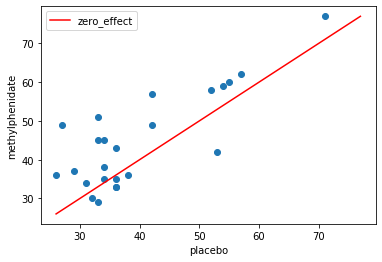

In [75]:
plt.scatter(adhd_data['Placebo'], adhd_data['Methylphenidate'])
zero_effect = np.linspace(adhd_data.min().values.min(), adhd_data.max().values.max(), 100)
plt.plot(zero_effect, zero_effect, 'r', label='zero_effect')
plt.xlabel('placebo')
plt.ylabel('methylphenidate')
plt.legend()
plt.show()

Чтобы показать разницу при использовании препората можно воспользоваться двухвыборочный критерий Стьюдента

Для того, чтобы использовать двухвыборочный критерий Стьюдента, убедимся, что распределения в выборках существенно не отличаются от нормальных.
Для этого можно воспользоваться QQ-plot

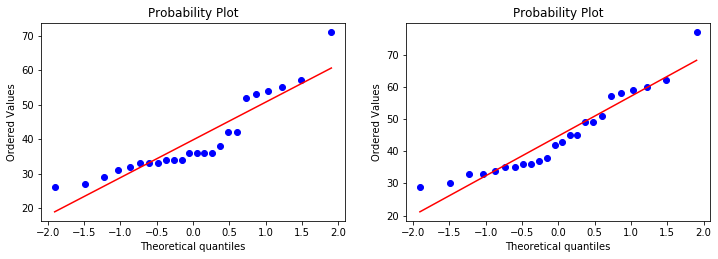

In [76]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
stats.probplot(adhd_data.Placebo, dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(adhd_data.Methylphenidate, dist="norm", plot=plt)
plt.show()

Критерий Шапиро-Уилка:

 $H_0\colon$ способности к подавлению импульсивных реакций распредлены нормально
 
 $H_1\colon$ не нормально.

In [77]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(adhd_data.Placebo))

Shapiro-Wilk normality test, W-statistic: 0.857487, p-value: 0.003020


Как мы видим, гипотеза о нормальности отвергается на 5 % уровне значимости

С помощью критерия Стьюдента проверим гипотезу о развенстве средних двух выборок.

Критерий Стьюдента:

$H_0\colon$ средние значения способности к подавлению испульсивных поведенческих реакций одинаковы для пациентов, принимавших препарат, и для пациентов, принимавших плацебо.

$H_0\colon$ не одинаковы.

In [78]:
# equal_var = False так как у нас информации что дисперсии в выборках одинаковы
statistic, p_value = stats.ttest_ind(adhd_data.Placebo, adhd_data.Methylphenidate, equal_var = False)
print(f'statistic:{np.round(statistic, 4)}, p_value: {p_value}')

statistic:-1.4522, p_value: 0.1532919977404709


Гипотеза не отвергается. Построим также доверительный интервал для разности

In [79]:
cm = CompareMeans(DescrStatsW(adhd_data.Methylphenidate), DescrStatsW(adhd_data.Placebo))
print("95%% confidence interval: [%f, %f]" % cm.tconfint_diff(usevar='unequal'))

95% confidence interval: [-1.915927, 11.832593]


Однако что выборки у нас связаны! Поэтому можно воспользоваться Критерием Стьюдента для связных выборок.

Для того, чтобы использовать критерй Стьюдента для связанных выборок, давайте проверим, что распределение попарных разностей существенно не отличается от нормального.

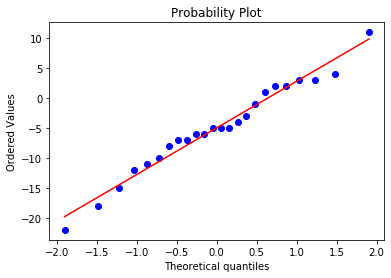

In [80]:
stats.probplot(adhd_data.Placebo - adhd_data.Methylphenidate, dist = "norm", plot = plt)
plt.show()

In [81]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(adhd_data.Methylphenidate - adhd_data.Placebo))

Shapiro-Wilk normality test, W-statistic: 0.979806, p-value: 0.892254


Гипотеза о нормальности не отвергается!

Критерий Стьюдента:

$H_0\colon$ средние значения способности к подавлению испульсивных поведенческих реакций одинаковы для пациентов, принимавших препарат, и для пациентов, принимавших плацебо.

$H_1\colon$ не одинаковы.

In [82]:
statistic, p_value = stats.ttest_rel(adhd_data.Methylphenidate, adhd_data.Placebo)
print(f'statistic:{np.round(statistic, 4)}, p_value: {p_value}')

statistic:3.2224, p_value: 0.003771488176381471


Гипотеза о равентсве отвергается на уровне значимости 5%

Также моно построить доверительный интервал

In [83]:
print("95%% confidence interval: [%f, %f]" % DescrStatsW(adhd_data.Methylphenidate - adhd_data.Placebo).tconfint_mean())

95% confidence interval: [1.775236, 8.141431]


# Непараметрические критeрии

В параметрических критериях делалось предположение из какого распределения взята случайная величина и после этого проверялись гипотезы о параметрах этого распределения. Однако это не всегда возможно сделать. В таком случае есть 2 выхода: 

- имеющуюся выборку из неизвестного распределения можно преобразовать так, чтобы ее распределение превратилось во что-то более конкретное и знакомое
- можно сделать какие-то предположения о функции распределения исходной выборки F(x), и на основании этих предположений построить статистику, нулевое распределение которой можно оценить.

## Критерии знаков

Этот критерий позволяет проверять гипотезы о значении медианы для выборки. 

Этот критерий обладают невысокой мощностью, но он крайне универсален и практически ничего не требует от данных, поэтому он очень полезен на практике. Единственное требование при применении этого критерий — в выборке не должно быть ни одного объекта,значение признака которого в точности совпадает с $m_0$(медианой)

<img src="images/sign_tests_description_of_the_one_sample_sign_test.png"  width="500px" title="aaa">

Если нулевая гипотеза справедлива, то каждый элемент с равной вероятностью получит значение 0 или 1, таким образом T статистика будет иметь биномиальное распределение.

## Критерий знаков для связанных выборок

Критерий знаков можно обобщить на связные выборки

<img src="images/sign_criteria_description_of_the_sign_criterion_for_linked_samples.png"  width="500px" title="aaa">


## Критерий знаковых рангов Уилкоксона(W-критерий Вилкоксона)

Для проверки гипотез о средних критерии знаков выбрасывают большую часть информации, содержащуюся в выборке. Вместо исходных значений признака используется бинарный вектор. Ранговые критерии позволяют сохранить больше информации.

Выборку $X_1,...,X_n$

Можно превратить в вариационный ряд, то есть упорядочить её по неубыванию $X_{(1)} ≤...<X_{(k1)} =...=X_{(k2)} <...≤X_{(n)}$

Если при этом есть какие-то части вариационного ряда, в которых элементы полностью совпадают, эти части называются «связками».

Рангом наблюдения $X_i$ называется его позиция в вариационном ряду. Если $X_i$ не попадает в связку, то $rank(X_i)=r:X_i =X_{(r)}$ а если Xi оказывается в связке $X_{(k1)}, . . . , X_{(k2)}$,  то $rank(Xi)= \frac{k_1 +k_2}{2}$, то есть в связке все объекты получают одинаковый средний ранг.

<img src="images/description_of_wilcoxon_signed_rank_test.png"  width="550px" title="aaa">

При справедливости нулевой гипотезы каждый из рангов в выборке мог с одинаковой вероятностью реализоваться с любым знаком. Таким образом, получается 2n вариантов распределения знаков по рангам. Перебирая все эти варианты, для каждого из них можно вычислить значение статистики. При этом с ростом объёма выборки нулевое распределение становится похожим на нормальное. При этом есть довольно сильное предположение о симметричности распределения относительно медианы!

## Двуxвыборочная задача со связанными выборками

Двухвыборочная задача со связанными выборками решается с использованием того же самого критерия, что и одновыборочная

<img src="images/description_of_the_signed_rank_test_for_related_samples.png"  width="550px" title="aaa">


## Двухвыборочная задача с независимыми выборками(критерий Манна-Уитни)

<img src="images/description_of_the_mann_whitney_test.png"  width="550px" title="aaa">

Для критерия Манни-Уитни также можно использовать нормальную аппроксимация нулевого распределения, если в каждой из выборок есть по меньшей мере десять объектов. При этом здесь есть сильное предположение что распределение между 2 выборками отличается только на сдвиг!

In [84]:
from scipy import stats

from statsmodels.stats.descriptivestats import sign_test

## Задача

Предположим что мы обучили классификатор и после его как-то улучшили(например подобрали какой-то гиперпараметр). Мы протестировали эти классификаторы на 14 датасетах и оказалось что на 2 лучше первый, на 10 второй. Можно ли сказать что второй лучше чем первый?

C помощью критерия знаков можно проверить следующую гипотезу:

$H_0\colon P\left(X_1>X_2\right)=\frac1{2},$

$H_1\colon P\left(X_1>X_2\right)\neq\frac1{2}$

In [85]:
auc_evaluation = pd.read_csv('./data/auc_evaluation.csv', sep='\t')
auc_evaluation.columns = ['dataset'] + list(auc_evaluation.columns[1:])
auc_evaluation = auc_evaluation[['dataset', 'C4.5', 'C4.5+m']]
auc_evaluation

,dataset,C4.5,C4.5+m
0,adult (sample),0.763,0.768
1,breast cancer,0.599,0.591
2,breast cancer wisconsin,0.954,0.971
3,cmc,0.628,0.661
4,ionosphere,0.882,0.888
5,iris,0.936,0.931
6,liver disorders,0.661,0.668
7,lung cancer,0.583,0.583
8,lymphography,0.775,0.838
9,mushroom,1.000,1.000


In [87]:
# делим на 2 так как односторонняя алтернатива
p_value = sign_test(auc_evaluation['C4.5+m'] - auc_evaluation['C4.5'])[1] / 2 
print('p_value:', p_value)

p_value: 0.019287109375


Таким образом можно сказать что второй классификатор занчимо лучше чем первый

## Задача №2

16 лабораторных мышей были помещены в двухкомнатные клетки, в одной из комнат висело зеркало. С целью установить, есть ли у мышей какие-то предпочтения насчет зеркал, измерялась доля времени, которое каждая мышь проводила в каждой из своих двух клеток.

In [88]:
mouses_data = pd.read_csv('mirror_mouses.txt', header = None)
mouses_data.columns = ['proportion_of_time']
mouses_data.head()

,proportion_of_time
0,0.348471
1,0.640620
2,0.549818
3,0.537454
4,0.400444


Построим гистограмму для доли

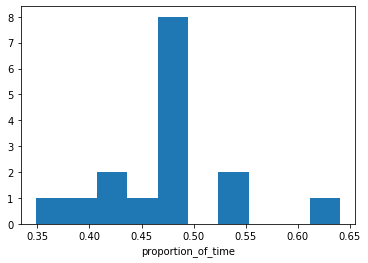

In [89]:
plt.hist(mouses_data.proportion_of_time)
plt.xlabel('proportion_of_time')
plt.show()

Итак имеем 2 гипотизы. для этого можно воспользоваться критерием знаков

$H_0\colon$ медиана доли времени, проведенного в клетке с зеркалом, равна 0.5

$H_1\colon$ медиана доли времени, проведенного в клетке с зеркалом, не равна 0.5

In [90]:
print("M: %d, p-value: %f" % sign_test(mouses_data, 0.5))

M: -5, p-value: 0.021271


Можно воспользоваться критерием знаковых рангов Уилкоксона

In [91]:
m0 = 0.5
stats.wilcoxon(mouses_data.proportion_of_time - m0)

WilcoxonResult(statistic=35.0, pvalue=0.09344482421875)

Как мы видим тесты дают разный результат! КАК ЭТО БЛЯТЬ ИНТЕРПРЕТИРОВАТЬ????

## Задача №3

В исследовании оценивается эффективность поведенческой терапии для лечения анорексии. Для 50 пациентов известен вес до начала терапии и по её окончании. Была ли терапия эффективной?

In [92]:
weight_data = pd.read_csv('weight.txt', sep = '\t', header = 0)
weight_data.head()

,Before,After
0,80.5,82.2
1,84.9,85.6
2,81.5,81.4
3,82.6,81.9
4,79.9,76.4


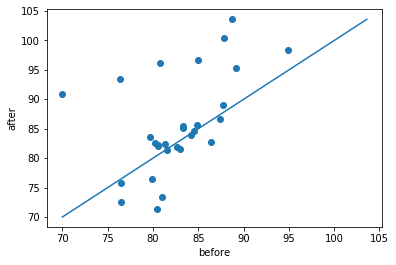

In [93]:
plt.scatter(weight_data['Before'], weight_data['After'])
min_weight, max_weight = weight_data.min().values.min(), weight_data.max().values.max()
plt.plot(np.linspace(min_weight, max_weight, 50), np.linspace(min_weight, max_weight, 50))
plt.xlabel('before')
plt.ylabel('after')
plt.show()

C помощью критерия знаков можно проверить следующую гипотезу:

$H_0\colon P\left(X_1>X_2\right)=\frac1{2},$

$H_1\colon P\left(X_1>X_2\right)\neq\frac1{2}$

In [94]:
print("M: %d, p-value: %f" % sign_test(weight_data.After - weight_data.Before))

M: 3, p-value: 0.264931


Как видно нулевая гипотеза не отвергается

C помощью критерия знаковых рангов Уилкоксона можно проверить другую гипотизу:

$H_0\colon med\left(X_1-X_2\right)=0,$

$H_1\colon med\left(X_1-X_2\right)\neq0$

In [95]:
stats.wilcoxon(weight_data.After, weight_data.Before)

WilcoxonResult(statistic=131.5, pvalue=0.06291972262602667)

Как видно и это гипотеза не отвергается. Можно сделать вывод что у нас нет оснований полагать что терапия работает. Возможно стоит собрать больше данных

## Задача № 4

Имеются данные о продажной стоимости недвижимости в Сиэтле для 50 сделок в 2001 году и 50 в 2002. Изменились ли в среднем цены?


In [96]:
seattle_data = pd.read_csv('./data/seattle.txt', sep = '\t', header = 0)
seattle_data.head()

,Price,Year
0,142.0,2002
1,232.0,2002
2,132.5,2002
3,200.0,2002
4,362.0,2002


__Ранговый критерий Манна-Уитни__

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [97]:
price2001 = seattle_data[seattle_data['Year']  == 2001].Price
price2002 = seattle_data[seattle_data['Year']  == 2002].Price
statistic, p_value = stats.mannwhitneyu(price2001, price2002)
print(f'statistic: {np.round(statistic, 4)}')
print(f'p_value: {p_value}')

statistic: 1295.5
p_value: 0.7563872675701748


То есть гипотизу о том что распределение цен на квартиры не изменилось отвергнуть нельзя

## Задача №5

Есть данным выживаемости пациентов с лейкоцитарной лимфомой:

$49, 58, 75, 110, 112, 132, 151, 276, 281, 362^*$
 

Измерено остаточное время жизни с момента начала наблюдения (в неделях); звёздочка обозначает цензурирование сверху — исследование длилось 7 лет, и остаточное время жизни одного пациента, который дожил до конца наблюдения, неизвестно.

Есть гипотеза что медианное время дожития это 200 недель.

На этих данных можно использовать критерий знаковых рангов — можно считать, что время дожития последнего пациента в точности равно 362, на ранг этого наблюдения это никак не повлияет. 

In [98]:
x = np.array([49, 58, 75, 110, 112, 132, 151, 276, 281, 362])
median = 200
p_value = np.round(stats.wilcoxon(x - median, mode='approx').pvalue, 4)
print('p_value:', p_value)

p_value: 0.2845


Как видно из этих данных деньзя опровергнуть нулевую гипотезу. То есть мы не можем утверждать что медианное время дожития это 200 недель

## Задача №6

В ходе исследования влияния лесозаготовки на биоразнообразие лесов острова Борнео собраны данные о количестве видов деревьев в 12 лесах, где вырубка не ведётся:

$22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15$

и в 9 лесах, где идёт вырубка:

$17, 18, 18, 15, 12, 4, 14, 15, 10$

Проверьте гипотезу о равенстве среднего количества видов в двух типах лесов против односторонней альтернативы о снижении биоразнообразия в вырубаемых лесах.

In [99]:
x_1 = [22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15]
x_2 = [17, 18, 18, 15, 12, 4, 14, 15, 10]
p_value = np.round(stats.mannwhitneyu(x_1, x_2, alternative='greater').pvalue, 4)
print('p_value:', p_value)

p_value: 0.029


Можно сделать вывод что вырубка статистически значимо уменьшает разнообразие леса

# Корреляции

Корреляция это способ численно вычислять силу взаимосвязи между величинами

## Корреляция Пирсона

Самый распространенный способ формализации корреляции — это коэффициент корреляции Пирсона. Кор- реляция Пирсона — это мера силы линейной взаимосвязи между двумя случайными величинами $X_1$ и $X_2$. Определяется она следующим образом:

$r_{X_1X_2} = \dfrac{\mathbb{E}((X_1 - \mathbb{E}X_1)(X_2 - \mathbb{E}X_2))}{\sqrt{\mathbb{D}X_1\mathbb{D}X_2} }$

где $r_{X_1X_2} = 1$ соответствует идеальной линейной взаимосвязи между случайными величинами, в которой при росте $X_1$ растет и $X_2$.  $r_{X_1X_2} = −1$ — это идеальная линейная связь с отрицательным знаком, то есть, когда $X_1$ растет, $X_2$ падает. $r_{X_1X_2} = 0$ — это случай отсутствия корреляции; это значит, что две случайные величины меняются независимо друг от друга.

Если имеется выборка пар $(X_{1i},X_{2i})$ объема $n$, по ней очень легко посчитать выборочный коэффициент корреляции Пирсона:

$r_{X_1X_2} = \dfrac{\sum_{i=1}^n (X_{1i} - \overline{X_1})(X_{2i} - \overline{X_2})}{\sqrt{\sum_{i=1}^n (X_{1i} - \overline{X_1})^2\sum_{i=1}^n (X_{2i} - \overline{X_2})^2}}$

Рассмотрим как меняется корреляция Пирсона при размытии облака точек
<img src="images/сhange_in_Pearsons_correlation_when_blurring_a_point_cloud.png"  width="800px" title="aaa">

Нужно помнить что корреляция Пирсона это степень именно линейной зависимости и даже если связь будет монотонная то коэффициент корреляции будет падать

<img src="images/сhange_in_the_Pearson_correlation_with_an_increase_in_cloud_bending_point.png"  width="800px" title="aaa">

Кроме того корреляция Пирсона крайне чувствительна к выбросам

<img src="images/effect_of_outliers_on_the_pearson_correlation_coefficient.png"  width="800px" title="aaa">

## Корреляция Спирмена

Коэффициент корреляции Спирмена — это мера силы монотонной взаимосвязи между двумя случайными величинами, он равен коэффициенту корреляции Пирсона между рангами наблюдений. Для того, чтобы ее посчитать, нужно выборку пар $(X_{1i} , X_{2i}) , i = 1, . . . , n$ превратить наблюдение в каждой из подвыборок в ранги  $rank(X_{1i})$ , взять $rank(X_{2i})$, и уже на этих рангах посчитать значение коэффициента корреляции Пирсона. Именно за счет рангового преобразования получается, что корреляция Спирмена чувствительна к любой монотонной взаимосвязи между $X_1$ и $X_2$, поскольку ранговое преобразование превращает любую монотонную взаимосвязь в линейную.
Корреляция Спирмена наследует часть свойств корреляции Пирсона. Она точно так же меняется от −1 до 1, где крайние значения отрезка соответствуют идеальной, в данной случае монотонной, взаимосвязи между случайными величинами, а 0 — полному отсутствию монотонной взаимосвязи между ними.

Если имеется выборка пар $(X_{1i} , X_{2i}) , i = 1, . . . , n$ то выборочный коэффициент корреляции Спирмена вычисляется следующим образом:

$ρ_{X_1X_2} = \dfrac{\sum_{i=1}^n(rank(X_{1i}) - \frac{n+1}{2})(rank(X_{2i}) - \frac{n+1}{2})}{\frac{1}{12(n^3 - n)}}$ 

Можно упростить:

$ρ_{X_1X_2} = 1 - \dfrac{6}{(n^3-n)}\sum_{i=1}^n(rank(X_{1i} - rank(X_{2i}))^2$

Корреляция Спирмена примерно так же, как и корреляция Пирсона, реагирует на сжатие и размыва- ние облака точек на диаграмме рассеяния. Однако при изгибе, корреляция Спирмена не убывает(до тех пор пока зависимость остается монотонной, а не как в последнем примере)

<img src="images/change_in_spearman_correlation__with_an_increase_in_the_curvature_of_the_point_cloud.png"  width="800px" title="aaa">

Коэффициент корреляции Спирмена гораздо более устойчив к выбросам, то есть, небольшое количество точек с нетипичными значениями признаков очень слабо влияют на выборочное значение коэффициента корреляции.

<img src="images/effect_of_outliers_on_the_spearman_correlation_coefficient.png"  width="800px" title="aaa">

## Корреляция и причинно-следственная связь

Нужно всегда помнить что корреляция еще не означает причинно-следственную связь. Например, количество продаваемого мороженного значимо коррелирует с количеством утонувших. Но оба этих признака скорректированы с средней температурой воздуха что логично и она уже объясняет оба этих факта.

Иногда бывает что корреляция между различными показателями просто случайна.

## Задача
Есть ли связь между неграмотностью и рождаемостью? Для 94 стран, уровень неграмотности женщин в которых больше 5%, известны доля неграмотных среди женщин старше 15 (на 2003 год) и средняя рождаемость на одну женщину

In [100]:
fertility = pd.read_csv('./data/fertility.txt', sep='\t')
fertility.head()

,Country,Illit,Births
0,Albania,20.5,1.78
1,Algeria,39.1,2.44
2,Bahrain,15.0,2.34
3,Belize,5.9,2.97
4,Benin,73.5,5.60


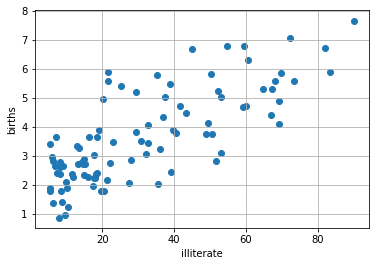

In [101]:
illiterate = fertility.sort_values('Illit')['Illit'].values
births = fertility.sort_values('Illit')['Births'].values
plt.scatter(illiterate, births)
plt.xlabel('illiterate')
plt.ylabel('births')
plt.grid()
plt.show()

На графике видна сильная линейная зависимость

Для этой задачи можно использовать корреляцию Пирсона

In [102]:
correlation, p_value = stats.pearsonr(fertility['Illit'], fertility['Births'])
print('pearson correlation:', np.round(correlation, 4))
print('p_value:', p_value)

pearson correlation: 0.7687
p_value: 1.5029095259924921e-19


Можно воспользоваться корреляцией Спирмена

In [103]:
correlation, p_value = stats.spearmanr(fertility['Illit'], fertility['Births'])
print('spearman correlation:', np.round(correlation, 4))
print('p_value:', p_value)

spearman correlation: 0.753
p_value: 2.0858571221460674e-18


Как видим между образование есть сильная и статистически значимая связь

## Задача №2

Для 61 большого города в Англии и Уэльсе известны средняя годовая смертность на 100000 населения (по данным 1958–1964) и концентрация кальция в питьевой воде (в частях на маллион). Чем выше концентрация кальция, тем жёстче вода. Города дополнительно поделены на северные и южные.

Есть ли связь между жёсткостью воды и средней годовой смертностью? 

In [104]:
water = pd.read_csv('./data/water.txt', sep='\t')
water.head()

,location,town,mortality,hardness
0,South,Bath,1247,105
1,North,Birkenhead,1668,17
2,South,Birmingham,1466,5
3,North,Blackburn,1800,14
4,North,Blackpool,1609,18


Посчитаем корреляцию между смертностью и жесткостью воды

In [106]:
correlation, p_value = stats.pearsonr(water['hardness'], water['mortality'])
print('pearson correlation:', np.round(correlation, 4))
print('pearson p_value:', p_value)

correlation, p_value = stats.spearmanr(water['hardness'], water['mortality'])
print('spearman correlation:', np.round(correlation, 4))
print('spearman p_value:', p_value)

pearson correlation: -0.6548
pearson p_value: 1.0331339260349462e-08
spearman correlation: -0.6317
spearman p_value: 4.79546153722838e-08


Рассмотрим отдельно Северные и Южные города

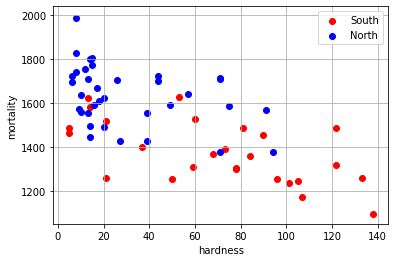

In [107]:
south_mortality = water[water['location'] == 'South']['mortality'].values
north_mortality = water[water['location'] == 'North']['mortality'].values
south_hardness = water[water['location'] == 'South']['hardness'].values
north_hardness = water[water['location'] == 'North']['hardness'].values
plt.scatter(south_hardness, south_mortality, label='South', color='red')
plt.scatter(north_hardness, north_mortality, label='North', color='blue')
plt.xlabel('hardness')
plt.ylabel('mortality')
plt.grid()
plt.legend()
plt.show()

In [109]:
correlation, p_value = stats.pearsonr(south_mortality, south_hardness)
print('south: pearson correlation:', np.round(correlation, 4))
print('south: pearson p_value:', p_value)
correlation, p_value = stats.pearsonr(north_hardness, north_mortality)
print('north: pearson correlation:', np.round(correlation, 4))
print('north: pearson p_value:', p_value)

south: pearson correlation: -0.6022
south: pearson p_value: 0.0011346743048161897
north: pearson correlation: -0.3686
north: pearson p_value: 0.029344659047110602


Как видно, для северных городов корреляция уменьшилась в 2 раза, по всей видимости связь между смертнотью не такая сильная как можно было предположить по предыдущему эксперименту

## Корреляция Мэтьюса

Коэффициент корреляции Мэтьюса — это мера силы взаимосвязи между двумя бинарными переменными.

<img src="images/contingency_table.png"  width="200px" title="aaa">

Коэффициент корреляции Мэтьюса вычисляется по данным из таблицы сопряжённости следующим образом:

$MCC_{X_1X_2} = \dfrac{ad-bc}{\sqrt{(a+b)(a+c)(b+d)(c+d)}}$

Точно так же, как и коэффициенты Пирсона и Спирмена, корреляция Мэтьюса лежит в диапазоне от −1 до 1. $MCC_{X_1X_2} = 0$ точно так же соответствует случаю полного отсутствия взаимосвязи между переменными.$MCC_{X_1X_2} = 1$ соответствует ситуации, когда у $X_1$ и $X_2$ полностью совпадают, то есть $b = c = 0$, в выборке отсутствуют объекты, на которых значения $X_1$ и $X_2$ отличаются. $MCC_{X_1X_2} = −1$ — это противоположная ситуация: в выборке нет ни одного объекта, на которых значения двух бинарных признаков совпадают.

## Коэффициент V Крамера

Этот подход можно обобщить на случай категориальных признаков. Пусть случайная величина $X_1$ принимает $K_1$ различных значений, а $X_2$ — $K_2$ разных значений. Можно составить большую таблицу сопряженности

<img src="images/conjugacy_table_K_K.png"  width="300px" title="aaa">

На основании этой таблицы сопряженности вычисляется мера взаимосвязи между X1 и X2. Эта мера называется коэффициентом V Крамера. Он обозначается $\phi_c$, и равен корню из специальным образом нормированного значения статистики хи-квадрат:

$\phi_{X_1^nX_2^n} = \sqrt{\dfrac{\chi^2(X_1^n, X_x^n)}{n((min(K_1, K_2) - 1)}}$

Коэффициент Крамера принимает значения исключительно в интервале от 0 до 1, то есть он не может быть отрицательным. 0, как и раньше, соответствует полному отсутствию взаимосвязи, а 1 — полному совпадению переменных $X_1$ и $X_2$ с точностью до переименования уровней. Корреляция между двумя категориальными переменными не может быть отрицательной, поскольку уровни категориальных переменных не связаны друг с другом отношениями порядков.

## Задача 3

Среди респондентов General Social Survey 2014 года хотя бы раз в месяц проводят вечер в баре 203 женщины и 239 мужчин; реже, чем раз в месяц, это делают 718 женщин и 515 мужчин.  

Есть ли зависимость между полом и частотой похода в бары?

In [111]:
bars_sex = np.array([[203., 239.],
                     [718., 515.]])

def calculate_matthews_correlations(a: int, b: int, c: int, d: int) -> float:
    numerator = a * d - b * c
    denominator = np.sqrt((a + b)*(a + c)*(b + d)*(c + d))
    return numerator / denominator

matthews_correlations = calculate_matthews_correlations(*bars_sex.flatten())
n = 718 + 203 + 515 + 239

p_value = stats.chi2_contingency(bars_sex)[1]
print('matthews_correlations:', np.round(matthews_correlations, 4))
print('p_value:', p_value)

matthews_correlations: -0.109
p_value: 1.0558987006638725e-05


Посчитаем доверительный интервал между долями мужчин и женщин которые ходят в бары

In [112]:
# ToDo переделать!
n_samples_1 = 239 + 515
n_samples_2 = 203 + 718
p1 = 239 / n_samples_1
p2 = 203 / n_samples_2
alpha = 0.05
z = stats.norm.ppf(1 - alpha / 2.)
left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n_samples_1 + p2 * (1 - p2)/ n_samples_2)
right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n_samples_1 + p2 * (1 - p2)/ n_samples_2)
print(np.round([left_boundary, right_boundary], 4))

[0.0539 0.1392]


Проверим гипотезу о равенстве долей любителей часто проводить вечера в баре среди мужчин и женщин

In [61]:
# ToDo переделать!
# Внимательно пересмотреть!!!
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = np.sum(sample1)
    n2 = np.sum(sample2)
    
    p1 = sample1[0] / n1
    p2 = sample2[0] / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

p_value = proportions_diff_z_test(proportions_diff_z_stat_ind(bars_sex[:,1], bars_sex[:,0]))
print('p_value:', p_value)

p_value: 8.153453089576601e-06


Гипотеза отвергается на любом разумном уровне значимости

Посмотрим на данные General Social Survey 2014 года и проанализируем, как связаны ответы на вопросы "Счастливы ли вы?" и "Довольны ли вы вашим финансовым положением?"

  | | Не доволен | Более или менее |   Доволен
  ------------- | -------------| -------------| -------------| 
  Не очень счастлив  | 197 | 111 | 33
  Достаточно счастлив  | 382 | 685 | 331
  Очень счастлив | 110| 342| 333 


In [113]:
conting = [[197,111,33],
           [382, 685, 331],
           [110, 342, 333]]
chi2, p_value, dof, expected = stats.chi2_contingency(conting)
v_cramer = np.sqrt(chi2 / (np.sum(conting) * 2))
print('v_cramer:', v_cramer)
print('p_value:', p_value)

v_cramer: 0.2412013934500338
p_value: 2.4964299580093467e-62


Можно сделать вывод что есть значимая корреляция между достатком и счастьем

# Проблема множественной проверки гипотез

При проверки гипотез всегда есть риск ошибки первого рода(отвергнуть нулевую гипотезу когда она верна), однако он строго ограничен уровнем значимости $\alpha$, проблемы начинают появляться когда проверяется множество гипотез, ведь резкие события имеют свойство сбываться. 


## Пример

Джозеф Райн в 50-ых годах придумал тест по определению у людей экстрасенсорных способностей. Он показывал кандидатам 10 карт и спрашивал какого они цвета.

<img src="images/card_guessing_experiment.png"  width="700px" title="aaa">

Проверялась нулевая гипотеза $H_0$ : испытуемый выбирает ответ наугад. Альтернативная гипотеза $H_1$ : испытуемый может предсказывать цвета карт. Статистика $t$ — число карт, цвета которых угаданы, — при справедливости нулевой гипотезы имеет биномиальное распределение с параметрами $n = 10, p = 0.5$, поскольку цвета только два, и они называются наугад. Вероятность правильно назвать цвета 9 и более карт: 

$P(t≥9|H0) = 10 \times (\dfrac{1}{2})^{10} + (\dfrac{1}{2})^{10} \approx 0.01$

То есть в случае успеха, нулевая гипотеза отвергает на любом разумном уровне значимости.В экспериментах Джозефа Райна процедуру отбора прошли 1000 человек. Девять из них угадали цвета 9 из 10 карт, еще двое угадали все 10 карт. Ни один из этих испытуемых в последующих экспериментах не подтвердил своих способностей.

Если принять гипотезу о том, что экстрасенсов не существует, то вероятность того, что из тысячи человек хотя бы один случайно угадает цвета 9 или 10 из 10 карт:

$1 - (1 -11\times (\dfrac{1}{10})^{10})  \approx 0.999$

При одновременной проверке большого количества гипотез вероятность совершить хотя бы одну ошибку первого рода (то есть ложно отвергнуть верную нулевую гипотезу) становится очень большой.

## Постановка задачи

Пусть имеет $m$ выборок и для каждой из них проверяется своя гипотеза и для каждой есть уровень значимости $p_i$

<img src="images/multiple_hypothesis_testing_problem.png"  width="700px" title="aaa">

Обозначим за $m_0$ количество верных нулевых гипотез и за $R$ количество гипотез которые отвергнуты. Тогда получается следующая таблица

<img src="images/information_about_true_and_false_accepted_and_rejected_hypotheses.png"  width="700px" title="aaa">


Единственный параметр, которым можно управлять, — это $R$, количество отвергаемых гипотез. При этом самая пугающая величина — это $V$ , количество ошибок первого рода. Хочется совершать мало ошибок первого рода, но при этом единственное, что можно делать, — это перераспределять по этой таблице гипотезы из второй строки в первую. То есть, чтобы совершать мало ошибок первого рода, нужно отвергать меньше гипотез.

## Групповая вероятность ошибки первого рода(FWER, FamilyWise Error Rate)

Можно аналогично обычной проверки гипотез ввезти вероятностное ограничение на ошибку первого рода. То есть ограничить  вероятность совершить хотя бы одну ошибку первого рода:

$FWER=P(V >0)≤α$


## Поправка Бонферрони

Самый простой способ решить поставленную выше задачу — это использовать поправку Бонферрони. В методе Бонферрони достигаемые уровни значимости всех гипотез сравниваются с величиной $\dfrac{a}{m}$ , то есть $\alpha_0 = \alpha_1 =...=\alpha_m = \dfrac{a}{m}$. 

В этом случае гарантируется что $FWER≤α$. Однако метод Бонферрнони очень грубый, при использовании метода Бонферрони на самом деле $FWER \ll \alpha$. Это приводит к уменьшении мощности теста, то есть количество ошибок второго рода(когда результат есть, но мы его не заметили) увеличиться.

In [424]:
import numpy as np
from scipy import stats

from statsmodels.stats.multitest import multipletests

In [426]:
# генерация выборок
N_0 = 150
N_1 = 50
distribution_0 = np.random.normal(0, 1, (N_0, 20))
distribution_1 = np.random.normal(1, 1, (N_1, 20))
# вычисление p_value для каждого эксперимента
p_value_0 = np.array([stats.ttest_1samp(sample, 0).pvalue for sample in distribution_0])
p_value_1 = np.array([stats.ttest_1samp(sample, 0).pvalue for sample in distribution_1])
# результаты эксперимента без поправки на множественную проверку
alpha = 0.05
false_positive = (p_value_0 < alpha).sum()  # ошибка первого рода
true_negative = (p_value_0 >= alpha).sum()  # верно не отвергнутые
true_positive = (p_value_1 < alpha).sum()  # верно отвергнутые
false_negative = (p_value_1 >= alpha).sum()  # ошибка второго рода
print('false_positive(first type error):', false_positive)
print('true_negative:', true_negative)
print('true_positive:', true_positive)
print('false_negative(second type error):', false_negative)

# pезультаты эксперимента при использовании поправки Бонферрони
alpha /= (N_0 + N_1)
false_positive = (p_value_0 < alpha).sum()  # ошибка первого рода
true_negative = (p_value_0 >= alpha).sum()  # верно не отвергнутые
true_positive = (p_value_1 < alpha).sum()  # верно отвергнутые
false_negative = (p_value_1 >= alpha).sum()  # ошибка второго рода
print('false_positive(first type error):', false_positive)
print('true_negative:', true_negative)
print('true_positive:', true_positive)
print('false_negative(second type error):', false_negative)

false_positive(first type error): 7
true_negative: 143
true_positive: 50
false_negative(second type error): 0
false_positive(first type error): 0
true_negative: 150
true_positive: 25
false_negative(second type error): 25


Есть уже готовая реализация для этого

In [427]:
p_values = np.concatenate([p_value_0, p_value_1], axis=0)
# p_values: List[float]: p-value для каждой гипотезы
alpha: float = 0.05  # уровень значимости 
rejected, pvals_corrected, _, _= multipletests(p_values,
                                               alpha=alpha,
                                               method='bonferroni')

## Метод Холма

В методе Бонферрони уровни значимости для всех гипотез выбираются одинаковыми. Оказывается, если значения $a_i$ брать не одинаковыми, а разными, можно достичь лучшего результата.

Суть метода заключается в том чтобы отсортировать все p_value по возрастанию: $p_{(1)} ≤ p_{(2)} ≤ ... ≤ p_{(m)}$ и для каждого посчитать порог уровня значимости по которому гипотеза отклоняется: 

$α_1 = \dfrac{\alpha}{m}, α_2 = \dfrac{\alpha}{m - 1} , ..., α_i = \dfrac{\alpha}{m - i + 1}, ..., α_m=α.$

Дальше нужно самый маленький достигаемый уровень значимости $p_{(1)}$ сравнить с уровнем значимости $α_1$. Если  $p_{(1)} ≥ α_1$, то принимаются все нулевые гипотезы $H_{(1)}, H_{(2)}, . . . , H_{(m)}$, и процесс останавливается. Если $p_{(1)} < α_1$, то отклоняется гипотеза $H_{(1)}$, и процедура продолжается. На втором шаге сравниваются $p_{(2)}$ и $α_2$. Если $p_{(2)} ≥ α_2$, то принимаются все оставшиеся гипотезы  $H_{(2)}, H_{(3)}, . . . , H_{(m)}$, и процедура завершается. Если нет — $H_{(2)}$ отвергается, процедура продолжается, и т.д. Такая процедура называется нисходящей.

Метод Холма всегда мощнее, чем метод Бонферрони, то есть, он всегда отвергает не меньше гипотез, чем метод Бонферрони, потому что его уровни значимости всегда не меньше, чем из метода Бонферрони.

Разберем это на том же примере

In [428]:
m = N_0 + N_1
alpha = 0.05
p_values = np.concatenate([p_value_0, p_value_1], axis=0)
sorted_idxs = np.argsort(p_values) # сортируем по возрастанию

In [429]:
rejected = np.zeros_like(p_values)  # 0 если не отклонили и 1 если отклонили, изначально все не отклонены
last_idx = 0
for idx, (sorted_idx, p_value) in enumerate(zip(sorted_idxs, p_values[sorted_idxs])):
    if p_value < alpha / (m - idx):  # для первого будет alpha / m  для последнего alpha / 1
        rejected[sorted_idx] = 1
    else:  # как только нашлась первая неотклоненная гипотеза, то все остальные нео твергаем
        last_idx = idx
        break

In [430]:
false_positive = int(rejected[: N_0].sum())  # ошибка первого рода
true_negative = N_0 - false_positive  # верно не отвергнутые
true_positive = int(rejected[N_0: ].sum())  # верно отвергнутые
false_negative = N_1 - true_positive  # ошибка второго рода
print('false_positive:', false_positive)
print('true_negative:', true_negative)
print('true_positive:', true_positive)
print('false_negative:', false_negative)

false_positive: 0
true_negative: 150
true_positive: 27
false_negative: 23


Есть уже готовая реализация для этого

In [431]:
# p_values: List[float]: p-value для каждой гипотезы
alpha: float = 0.05  # уровень значимости 
rejected, pvals_corrected, _, _= multipletests(p_values,
                                               alpha=alpha,
                                               method='holm')
# rejected: List[bool]: отвернута ли гипотеза или нет
# pvals_corrected: List[float]: скорректированные p-value

Визуализируем на одном графике все гипотезы: по горизонтальной оси отложен номер в вариационном ряду, а по вертикальной оси — значения соответствующего достигаемого уровня значимости и отметить верные и ложные гипотезы. 

В месте перехода верных и неверных гипотез их p-value перемешиваются и задача  множественной проверки гипотез— где-то в этом месте правильно поставить порог, чтобы обеспечить теоретические гарантии на число ошибок первого рода.

In [432]:
p_values_0 = {'idx': [], 'p_values': []}
p_values_1 = {'idx': [], 'p_values': []}
for idx, sorted_idx in enumerate(sorted_idxs):
    if sorted_idx < N_0:
        p_values_0['idx'].append(idx)
        p_values_0['p_values'].append(p_values[sorted_idx])
    else:
        p_values_1['idx'].append(idx)
        p_values_1['p_values'].append(p_values[sorted_idx])

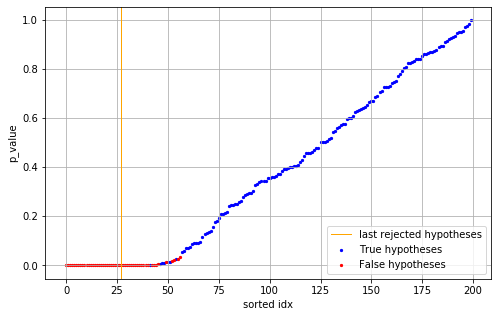

In [433]:
plt.figure(figsize=(8, 5))
plt.scatter(p_values_0['idx'], p_values_0['p_values'], color='blue', label='True hypotheses', s=5)
plt.scatter(p_values_1['idx'], p_values_1['p_values'], color='red', label='False hypotheses', s=5)
plt.grid()
plt.xlabel('sorted idx')
plt.ylabel('p_value')
plt.axvline(last_idx, color='orange', linewidth=1, alpha=1, label='last rejected hypotheses')
plt.legend()
plt.show()

## False Discovery Rate(FDR)

В описанных ранее поправках при множественном проверке гипотез контролировалась величина групповой вероятности ошибки, то есть ограничивалась вероятность совершить хотя бы одну ошибку первого рода:
$FWER=P(V >0).$
В некоторых ситуациях, например, когда проверяются десятки тысяч или миллионы гипотез, можно допу- стить какое-то количество ошибок первого рода ради того, чтобы увеличить мощность процедуры и отверг- нуть больше неверных гипотез, то есть совершить меньше ошибок второго рода. В таких ситуациях выгоднее использовать другую меру false discovery rate:

$FDR = E(\dfrac{V}{max(1, R)})$

$FDR$ это ожидаемую долю ложных отклонений(ошибок первого рода).Для любой фиксированной процедуры множественной проверки гипотез $FDR ≤ FWER$ . За счет этого, если контролировать $FDR$, а не $FWER$, получается более мощная процедура, поскольку она позволяет отвергать больше гипотез.

## Метод Бенджамини-Хохберга

Для контроля над $FDR$ чаще всего используется метод Бенджамини-Хохберга. Здесь также используются разные уровни значимости для разных гипотез:

$α_1 = \dfrac{\alpha}{m}, α_2 = \dfrac{2\times\alpha}{m} , ..., α_i = \dfrac{i \times \alpha}{m}, ..., α_m=α.$

Перед началом процедуры все p-value сортируются в порядке неубывания $p_{(1)} ≤ p_{(2)} ≤ ... ≤ p_{(m)}$. Отличие от метода Холма заключается в том, что процедура начинается с другого конца этого ряда. На первом шаге самый большой p-value pm сравнивается с соответствующей ему константой $α_m$. Если $p_{(m)} ≤ α_m$, то все нулевые гипотезы $H_{(1)}, H_{(2)}, . . . , H_{(m)}$ отвергаются, и процедура останавливается. Иначе гипотеза $H_{(m)}$ принимается, и процедура продолжается. На следующем шаге сравниваются $p_{(m−1)}$ и $α_{m−1}$. Если $p_{(m−1)} ≤ α_{m−1}$, то все нулевые гипотезы $H_{(1)}, H_{(2)}, . . . , H_{(m−1)}$ отвергаются, и процедура останавливается. Иначе принимается гипотеза $H_{(m−1)}$, процедура продолжается. И так далее. Такая процедура называется восходящей.

*Замечание*: метод Бенджамини-Хохберга обеспечивает контроль над FDR на уровне α только при условии независимости статистик, которые проверяют гипотезы. Это требование достаточно сильное.

In [434]:
m = N_0 + N_1
alpha = 0.05
p_values = np.concatenate([p_value_0, p_value_1], axis=0)
sorted_idxs = np.argsort(p_values)[::-1] # сортируем по убыванию для удобства

In [435]:
rejected = np.ones_like(p_values)  # 0 если не отклонили и 1 если отклонили, изначально все откленены
last_idx = 0
for idx, (sorted_idx, p_value) in enumerate(zip(sorted_idxs, p_values[sorted_idxs])):
    inverse_idx = m - idx  # инвертируем индексы обратно
    if p_value > alpha * inverse_idx / m:  # для первого будет alpha / m  для последнего alpha / 1
        rejected[sorted_idx] = 0
    else:  # как только нашлась первая отклоненная гипотеза, то все остальные твергаем
        last_idx = idx
        break

In [436]:
false_positive = int(rejected[: N_0].sum())  # ошибка первого рода
true_negative = N_0 - false_positive  # верно не отвергнутые
true_positive = int(rejected[N_0: ].sum())  # верно отвергнутые
false_negative = N_1 - true_positive  # ошибка второго рода
print('false_positive:', false_positive)
print('true_negative:', true_negative)
print('true_positive:', true_positive)
print('false_negative:', false_negative)

false_positive: 6
true_negative: 144
true_positive: 46
false_negative: 4


Есть уже готовая реализация для этого

In [437]:
# p_values: List[float]: p-value для каждой гипотезы
alpha: float = 0.05  # уровень значимости 
rejected, pvals_corrected, _, _= multipletests(p_values,
                                               alpha=alpha,
                                               method='fdr_bh')
# rejected: List[bool]: отвернута ли гипотеза или нет
# pvals_corrected: List[float]: скорректированные p-value

Визуализируем результаты

In [438]:
p_values_0 = {'idx': [], 'p_values': []}
p_values_1 = {'idx': [], 'p_values': []}
for idx, sorted_idx in enumerate(sorted_idxs):
    if sorted_idx < N_0:
        p_values_0['idx'].append(idx)
        p_values_0['p_values'].append(p_values[sorted_idx])
    else:
        p_values_1['idx'].append(idx)
        p_values_1['p_values'].append(p_values[sorted_idx])

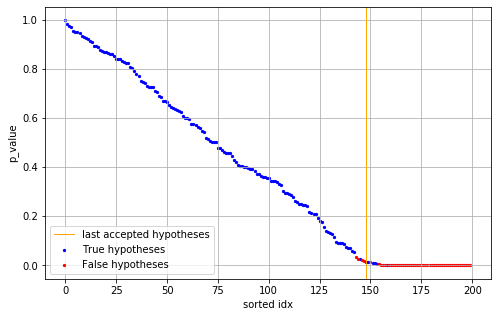

In [439]:
plt.figure(figsize=(8, 5))
plt.scatter(p_values_0['idx'], p_values_0['p_values'], color='blue', label='True hypotheses', s=5)
plt.scatter(p_values_1['idx'], p_values_1['p_values'], color='red', label='False hypotheses', s=5)
plt.grid()
plt.xlabel('sorted idx')
plt.ylabel('p_value')
plt.axvline(last_idx, color='orange', linewidth=1, alpha=1, label='last accepted hypotheses')
plt.legend()
plt.show()

### Замечание

Нужно понимать что самым простым и действенным способом меньше огрести при множественной проверки гипотез это проверять меньше гипотез. То есть проверять гипотезу если она прошла минимальный отбор. Пример: пусть есть 100 больных людей и 100 здоровых, и хочется понять, есть ли связь между болезнью и какой-то мутацией и гипотеза что связи нет будет отвергаться на 5% уровне значимости, однако если добавить еще одну голубую гипотезу(с какой буквы начинается фамилия больного), то какой бы при этом ни использовался метод поправки, будь то метод Бонферрони, Холма или Бенджамини Хохберга, самый маленький достигаемый уровень значимости во всех них сравнивается с $\frac{a}{m}$ и гипотеза о мутации не будет отвергаться.

<img src="images/data_from_a_hypothetical_experiment.png"  width="700px" title="aaa">


## Задача

У нас есть данные по набору магазинов разбитые по дням. Для каждого дня известно сколько в каждом магазине было куплено товаров. Хочется узнать какие товары связаны между собой(то есть с одним покупают другой). Для этого можно провестировать гипотизу о том что некоторые товары скоррелированы. Однако проблема в том что пар товаров очень много и нужно учитывать проблему множественной проверки гипотез

In [440]:
# загружаем данные
sales = pd.read_csv('./data/sales.csv', parse_dates = [2])
sales.head()

,product_id,store_id,date,sales,product_name
0,4,6,1997-01-01,4,Washington Cream Soda
1,4,7,1997-01-05,3,Washington Cream Soda
2,4,6,1997-01-06,2,Washington Cream Soda
3,4,17,1997-01-11,2,Washington Cream Soda
4,4,24,1997-01-11,2,Washington Cream Soda


In [441]:
# для удобства создаем таблицу сгруппированную по дням и магазинам и столбцы это количество каждого товара
# купленного в этот день в этом магазине
sparse_sales = pd.pivot_table(sales, values='sales', index=['date', 'store_id'],
                              columns=['product_name'], fill_value = 0)
sparse_sales.head()

product_name         ADJ Rosy Sunglasses  Akron City Map  \
date       store_id                                        
1997-01-01 6                           0               0   
           14                          0               0   
1997-01-02 11                          0               0   
           23                          0               0   
1997-01-03 7                           0               0   

product_name         Akron Eyeglass Screwdriver  American Beef Bologna  \
date       store_id                                                      
1997-01-01 6                                  0                      0   
           14                                 0                      0   
1997-01-02 11                                 0                      0   
           23                                 0                      0   
1997-01-03 7                                  0                      0   

product_name         American Chicken Hot Dogs  American Cole Slaw  \
date       store_id                                                  
1997-01-01 6                                 0                   0   
           14                                0                   0   
1997-01-02 11                                0                   0   
           23                                0                   0   
1997-01-03 7                                 0                   0   

product_name         American Corned Beef  American Foot-Long Hot Dogs  \
date       store_id                                                      
1997-01-01 6                            0                            0   
           14                           0                            0   
1997-01-02 11                           0                            0   
           23                           0                            0   
1997-01-03 7                            0                            0   

product_name         American Low Fat Bologna  American Low Fat Cole Slaw  \
date       store_id                                                         
1997-01-01 6                                0                           0   
           14                               0                           0   
1997-01-02 11                               0                           0   
           23                               0                           0   
1997-01-03 7                                0                           0   

product_name         ...  Washington Apple Juice  Washington Berry Juice  \
date       store_id  ...                                                   
1997-01-01 6         ...                       0                       0   
           14        ...                       0                       0   
1997-01-02 11        ...                       0                       0   
           23        ...                       0                       0   
1997-01-03 7         ...                       0                       4   

product_name         Washington Cola  Washington Cranberry Juice  \
date       store_id                                                
1997-01-01 6                       0                           0   
           14                      0                           0   
1997-01-02 11                      0                           0   
           23                      0                           0   
1997-01-03 7                       0                           0   

product_name         Washington Cream Soda  Washington Diet Cola  \
date       store_id                                                
1997-01-01 6                             4                     0   
           14                            0                     0   
1997-01-02 11                            0                     0   
           23                            0                     0   
1997-01-03 7                             0                     0   

product_name         Wa

Посчитаем корреляцию пиксона для каждой пары товаров и составим таблицу

In [561]:
%%time 
corr_data = []
for i, lhs_column in enumerate(sparse_sales.columns):
    for j, rhs_column in enumerate(sparse_sales.columns):
        if i >= j:
            continue
        
        corr, p = stats.pearsonr(sparse_sales[lhs_column], sparse_sales[rhs_column])
        corr_data.append([lhs_column, rhs_column, corr, p])
sales_correlation = pd.DataFrame.from_records(corr_data)
sales_correlation.columns = ['product_A', 'product_B', 'corr', 'p']
sales_correlation.head()

CPU times: user 1min 43s, sys: 489 ms, total: 1min 43s
Wall time: 1min 44s


,product_A,product_B,corr,p
0,ADJ Rosy Sunglasses,Akron City Map,0.076608,0.032414
1,ADJ Rosy Sunglasses,Akron Eyeglass Screwdriver,-0.006581,0.854396
2,ADJ Rosy Sunglasses,American Beef Bologna,0.038685,0.280546
3,ADJ Rosy Sunglasses,American Chicken Hot Dogs,0.041105,0.251529
4,ADJ Rosy Sunglasses,American Cole Slaw,-0.045887,0.200484


Проверим количество гипотез которые были отвергнуты без использования поправки на множественную проверку гипотез

In [545]:
(sales_correlation.p < 0.05).value_counts()

False    982453
True     232008
Name: p, dtype: int64

Воспользуемся __методом Холма__ для проверки гипотез

In [569]:
reject, p_corrected, a1, a2 = multipletests(sales_correlation.p, 
                                            alpha = 0.05, 
                                            method = 'holm') 
# запишим данные в таблицу
sales_correlation['p_corrected'] = p_corrected
sales_correlation['reject'] = reject

sales_correlation[sales_correlation.reject == True].sort_values(by='corr', ascending=False).head()

,product_A,product_B,corr,p,p_corrected,reject
1063670,Just Right Vegetable Soup,Plato French Roast Coffee,0.340598,1.226033e-22,1.488970e-16,True
885574,Great Muffins,Nationeel Grape Fruit Roll,0.322176,2.688803e-20,3.265443e-14,True
473067,Club Low Fat Cottage Cheese,Skinner Strawberry Drink,0.306701,1.883995e-18,2.288034e-12,True
1181001,Robust Monthly Home Magazine,Tri-State Lemons,0.303269,4.674973e-18,5.677558e-12,True
1160248,Pleasant Regular Ramen Soup,Shady Lake Ravioli,0.298502,1.619119e-17,1.966350e-11,True


Проверим сколько гипотез было отвергнуто в этом случае

In [570]:
sales_correlation.reject.value_counts()

False    1212733
True        1728
Name: reject, dtype: int64

Как мы видим мы не отвергли практически все гипотезы.

Вероятно мы можем позволить себе некоторое количество ошибок первого рода чтобы найти больше товаров которые связаны, поэтому воспользуемся __методом Бенджамини-Хохберга__

In [566]:
reject, p_corrected, a1, a2 = multipletests(sales_correlation.p, 
                                            alpha = 0.05, 
                                            method = 'fdr_bh') 
sales_correlation['p_corrected'] = p_corrected
sales_correlation['reject'] = reject

sales_correlation[sales_correlation.reject == True].sort_values(by='corr', ascending=False).head()

,product_A,product_B,corr,p,p_corrected,reject
1063670,Just Right Vegetable Soup,Plato French Roast Coffee,0.340598,1.226033e-22,1.488970e-16,True
885574,Great Muffins,Nationeel Grape Fruit Roll,0.322176,2.688803e-20,1.632723e-14,True
473067,Club Low Fat Cottage Cheese,Skinner Strawberry Drink,0.306701,1.883995e-18,7.626793e-13,True
1181001,Robust Monthly Home Magazine,Tri-State Lemons,0.303269,4.674973e-18,1.419393e-12,True
1160248,Pleasant Regular Ramen Soup,Shady Lake Ravioli,0.298502,1.619119e-17,3.932713e-12,True


Проверим сколько гипотез было отвергнуто в этом случае

In [567]:
sales_correlation.reject.value_counts()

False    1138407
True       76054
Name: reject, dtype: int64

Как мы видим в этом случае у нас уже есть намного больше отвергнутых гипотез

## Задача №2

Классификатор C4.5 и три его модификации: с оптимизацией гиперпараметра m, гиперпараметра cf и с одновременной оптимизацией обоих гиперпараметров. Эти четыре классификатора сравнивались на 14 наборах данных. На каждом датасете был посчитан AUC каждого классификатора.

In [598]:
auc_evaluation = pd.read_csv('./data/auc_evaluation.csv', sep='\t')
auc_evaluation.columns = ['dataset'] + list(auc_evaluation.columns[1:])
auc_evaluation.head()

,dataset,C4.5,C4.5+m,C4.5+cf,C4.5+m+cf
0,adult (sample),0.763,0.768,0.771,0.798
1,breast cancer,0.599,0.591,0.590,0.569
2,breast cancer wisconsin,0.954,0.971,0.968,0.967
3,cmc,0.628,0.661,0.654,0.657
4,ionosphere,0.882,0.888,0.886,0.898


Используем критерий знаковых рангов, чтобы провести попарное сравнение каждого классификатора с каждым

In [604]:
sign_test_data = []
for idx_1, model_1 in enumerate(auc_evaluation.columns[1:]):
    for idx_2, model_2 in enumerate(auc_evaluation.columns[1:]):
        if idx_1 >= idx_2:
            continue
        M, p_value = stats.wilcoxon(auc_evaluation[model_1] - auc_evaluation[model_2])
        sign_test_data.append([model_1, model_2, M, p_value])
# запишем результат в таблицу
sign_test_data = pd.DataFrame(sign_test_data)
sign_test_data.columns = ['model_1', 'model_2', 'M', 'p_value']
sign_test_data

/Users/v.s.dokholyan/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,model_1,model_2,M,p_value
0,C4.5,C4.5+m,6.5,0.010757
1,C4.5,C4.5+cf,43.0,0.861262
2,C4.5,C4.5+m+cf,11.0,0.015874
3,C4.5+m,C4.5+cf,18.0,0.054329
4,C4.5+m,C4.5+m+cf,22.0,0.327826
5,C4.5+cf,C4.5+m+cf,10.5,0.025314


Если не делать поправку на проблему множественной проверки гипотез мы отвергаем 3 гипотезы. Кроме того видно что параметр $m$ дает более значимое улучшение

Воспользуемся поправкой Холма для этой задачи

In [605]:
rejected, p_corrected, a1, a2 = multipletests(sign_test_data.p_value, 
                                            alpha = 0.05, 
                                            method = 'holm') 
sign_test_data['p_corrected'] = p_corrected
sign_test_data['rejected'] = rejected
sign_test_data

,model_1,model_2,M,p_value,p_corrected,rejected
0,C4.5,C4.5+m,6.5,0.010757,0.064543,False
1,C4.5,C4.5+cf,43.0,0.861262,0.861262,False
2,C4.5,C4.5+m+cf,11.0,0.015874,0.079372,False
3,C4.5+m,C4.5+cf,18.0,0.054329,0.162986,False
4,C4.5+m,C4.5+m+cf,22.0,0.327826,0.655651,False
5,C4.5+cf,C4.5+m+cf,10.5,0.025314,0.101254,False


Как видим что в этом случае мы не отвергаем никакие гипотезы. Попробуем использовать метод Бенджамини-Хохберга

In [606]:
rejected, p_corrected, a1, a2 = multipletests(sign_test_data.p_value, 
                                            alpha = 0.05, 
                                            method = 'fdr_bh') 
sign_test_data['p_corrected'] = p_corrected
sign_test_data['rejected'] = rejected
sign_test_data

,model_1,model_2,M,p_value,p_corrected,rejected
0,C4.5,C4.5+m,6.5,0.010757,0.047623,True
1,C4.5,C4.5+cf,43.0,0.861262,0.861262,False
2,C4.5,C4.5+m+cf,11.0,0.015874,0.047623,True
3,C4.5+m,C4.5+cf,18.0,0.054329,0.081493,False
4,C4.5+m,C4.5+m+cf,22.0,0.327826,0.393391,False
5,C4.5+cf,C4.5+m+cf,10.5,0.025314,0.050627,False


В этом случае мы отвергаем 2 гипотезы! И видим что параметр $m$ действительно дает значимый прирост, НО  статистики, соответствующие разным гипотезам, зависимы, так что предположения метода Бенджамини-Хохберга не выполняются, следовательно его использовать некорректно!

# A/B тестирование

Во всех сферах бизнеса постоянно требуется улучшать его ключевые показатели. Генерируется различные идея как это сделать. Один из вариантов проверить это использовать *A/B тестирование*.

Для того чтобы показать свою эффективность нужно провести эксперимент и показать что изменилась некоторая метрика. Можно разделить метрики на 3 категории:

- *целевые метрики* - это какие-либо бизнес показатели, как правило связаны с деньгами. Они бывают достаточно грубыми и практически не реагируют на небольшие изменения, кроме того чтобы их замерить нужно много времени.
- *прокси-метрики* - это метрики которые хорошо согласуется с бизнес показателями и при этом достаточно чувствительны чтобы их изменение можно было бы измерить. Пример: количество кликов на баннер. Другой пример: целевая метрики: продлит ли пользователь подписку на онлайн сервис в следующим месяце, прокси метрика: сколько времени он провел в сервисе за текущий месяц
- *оффлайн-метрики* - это метрики которые можно проверить на исторических данных. Должны коррелировать с онлайн метриками.

*Оффлайн-тестирование* - это тестирование гипотезы на исторических данных. Если это возможно то стоит сначала проверить идею на исторических данных.  Если окажется что оффлайн-метрики не выросли, то не стоит тратить время на тестирование

## Разбиение пользователей

Для того, чтобы результаты, полученные на этой небольшой группе можно было обобщать на всех пользователей, группа должна быть репрезентативной. 

Первый подход это *Стратификация.*  Для этого можно разбить пользователей на страты по признакам которые кажутся нам важными(например: на женщин и мужчин, по типу устройств и так далее)и сделать разбиение так чтобы соотношение страт в обоих группах совпадала с распределением в генеральной совокупности. Плюсом этого подхода является то что стратификация уменьшает дисперсию и это приводит к тому что тесты станут чувствительными.

Второй подход это  *рандомизация*.Если набирать пользователей в экспериментальную группу абсолютно случайно, то в среднем она получится такого же состава, как и вся генеральная совокупность пользователей. Дополнительный плюс рандомизации заключается в том, что при этом экспериментальная группа пользователей выравнивается со генеральной совокупностью по всем возможным показателям, а не только по тем, которые показались важными.

В некоторых случаях оказывается важным измерить, как на пользователя влияет несколько воздействий сразу, например, как он реагирует на сайт без изменений и на сайт с изменениями. Такой дизайн эксперимента называется *парным*, или *связанным*. Это очень выгодно в ситуациях, когда измеряемый показатель имеет большую индивидуальную дисперсию (то есть пользователи очень сильно отличаются по этому показателю). При связанном дизайне эксперимента зачастую оказывается важным, в каком порядке пользователю предъявляются разные варианты. Для того, чтобы снять влияние порядка, можно использовать дизайн крест- накрест: половине пользователей показать сначала новый вариант, потом — старый, а другой половине — наоборот.

## Устойчивость

*Устойчивость* означает что во-первых, хочется не видеть значимых изменений там, где их на самом деле нет, во вторых, если какие-то значимые изменения есть, то хочется, чтобы они отражались на метриках.

Чтобы проверить дизайн эксперимента на устойчивость можно воспользоваться                    *A/A тестированием*. Перед тем, как запускать классический A/Б тестинг, можно поделить пользователей на группы точно так же, как это сделали бы в рамках A/Б тестинга, но обеим группам демонстрировать один и тот же алгоритм. Этот эксперимент должен длиться ровно столько же, сколько бы длился A/Б тестинг. В результате нужно определить, видны ли значимые изменения на интересуемых метриках. Если есть значимые изменения то это должно наводить на мысль, что в дизайне эксперимента что-то не так( например, эксперимент длится недостаточно долго, или пользователи неправильно разбиты на группы.)

Другой способ проверить устойчивость это *Обратный эксперимент.* Пусть классический A/B-тест показал, некоторое изменение полезное, то есть по измеряемым метрикам наблюдаются значимые улучшения. После этого изменение должно раскатиться на всех пользователях. Однако можно оставить небольшую группу пользователям и не показывать ей новую фичу. Это позволит в течение большего срока рассчитывать те же самые метрики, что и в процессе A/Б-тестирования и проверить а на самом ли деле есть значимые улучшения. Такой подход предоставляет возможность убедиться в том, что изменения действительно значимы и приводят к ожидаемому эффекту. Пример: выкатили новый дизайн какой-то кнопки и пользователи начали чаще по ней проходить. A/B тест показал значимый прирост переходов. С течением времени выяснилось, пользователи нажимали на кнопку так как просто увидели изменение и решили его проверить(может что-то еще изменилось)

## Размер выборки

До начала эксперимента нужно понять а сколько он должен длиться и сколько пользователей должно в нем участвовать. Для того, чтобы понять, какой объем выборки необходим, нужно зафиксировать некоторые параметры. 

- минимальный размер эффекта, который хочется измерить. То есть, насколько большие отклонения от значения по умолчанию (показатель, который сохраняется, если изменения никак не влияют на пользователей) хочется наблюдать в эксперименте. Также размер эффекта можно высчитывать с помощью формулы Коэном(размер эффекта исходит из std выборки)
- допустимые вероятности ошибок первого и второго рода. В конкретном эксперименте стоимости ошибок первого и второго рода могут быть существенно разными, поэтому часто может оказаться выгодно вручную пороги. Часто ошибку второго рода фиксируют 0.8.
- статистический критерий

Для каждого критерия есть свой *калькулятор мощности*: по типу альтернативы, размеру эффекта и вероятностям ошибок первого и второго рода можно вычислить размер необходимой выборки([подробнее](https://ru.wikipedia.org/wiki/Статистическая_мощность))

# CUPED

Если размер эффекта не очень большой, а дисперсия выборки велика, то необходимо много данных чтобы обнаружить этот эффект. Самый простой вариант это использовать больше данных, для этого можно как увеличивать количество пользователей которые будут участвовать в эксперименте или увеличивать время эксперимента. Оба этих варианта достаточно дорогостоящие. Важно помнить что даже небольшой эффект может принести много выгоды!

<img src="images/variance_power_problem.png"  width="700px" title="aaa">

Однако можно попробовать уменьшить дисперсию целевой метрики, для этого можно использовать дополнительную информацию. Как правило у нас есть много исторических данных собранных до эксперимента. **CUPED** — техника A/Б-экспериментов, позволяющая увеличить чувствительность за счёт использования данных, полученных ранее.

Основная идея CUPED:

1. Наблюдаемая дисперсия частично обусловлена неустранимым разбросом, а частично связана с влиянием ненаблюдаемых нами факторов.
2. Если есть основания полагать эти факторы постоянными, то они так же влияли на исторические данные.
3. Если определить связь между историческими данными и данными в эксперименте, то дисперсию можно уменьшить.

<img src="images/variance_and_cuped.png"  width="400px" title="aaa">

Рассмотрим новую метрику $Z =Y −\theta X$, где $X$ это некоторая ковариата, а $\theta$ некоторая константа.  Это можно объяснить так: нас интересует не только то, как в среднем ведут себя пользователи, а то, как *изменилось их поведение*. Это позволяет вычитать некоторую объясняющую переменную.

В этом случае дисперсия новой метрики будет

 $\mathbb{V}Z = \mathbb{V}Y − 2\theta \times cov(Y , X ) + \mathbb{V}X$ .

Дисперсия зависит от $\theta$ квадратично и дисперсия будет минимальна при $\theta = \dfrac{cov(X, Y)}{\mathbb{V}(X)}$

Тогда минимальная дисперсия равна:

$min( \mathbb{V} Y ) = \mathbb{V}Y \times (1− \rho ), \rho = \dfrac{cov(X, Y)}{\mathbb{V}X \mathbb{V}Y}$

Любая коррелирующая с.в. может быть использована для уменьшения дисперсии. При этом важно чтобы эксперимент не влиял на $X$, примером модет служить пол пользователя, значение целевой переменной в предыдущем периоде и так далее.

Хорошей ковариатой будет та же самая метрика, но собранная на периоде до эксперимента. Если по одной оси отложить данные старого периода, а по другой — нового, то регрессия показывает наследуемость признаков, а остаток — изменчивость. Именно эту наследуемость мы хотим убрать. А изменчивость выделить. В ней содержится основной эффект.

<img src="images/cuped_and_regression.png"  width="500px" title="aaa">


## Задача № 1

Рассмотрим задачу определения есть ли статистическая разница в длине пользовательских сессий в пилоте или нет.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from typing import List

np.random.seed(33)

In [5]:
# генерация датасета

group_size = 100  # количество пользователей которые мы тестируем

# создадим данный за прошедший период
df_pilot = pd.DataFrame({'y_before': np.random.normal(120, 40, group_size)})
df_control = pd.DataFrame({'y_before': np.random.normal(120, 40, group_size)})
# за текущий период, чтобы создать некоторую наследственность будет генерировать его путем изменения старых значений
df_pilot['y'] = df_pilot['y_before'] + np.random.normal(0, 10, group_size)
df_control['y'] = df_control['y_before'] + np.random.normal(0, 10, group_size)
# добавим некоторый эффект
df_pilot['y'] += np.random.normal(5, 2, group_size)

In [36]:
def calculate_theta(y_control: List[float], y_pilot: List[float],
                    y_control_cov: List[float], y_pilot_cov: List[float]) -> float:
    """
    Вычисляем Theta.
    
    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    y_control_cov - значения ковариант на контрольной группе
    y_pilot_cov - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    y_cov = np.hstack([y_control_cov, y_pilot_cov])
    covariance = np.cov(y_cov, y)[0, 1]
    variance = y_cov.var()
    theta = covariance / variance
    return theta

In [7]:
# в качестве ковариат используем целевые метрики на предыдущем периоде

theta = calculate_theta(df_control['y'], df_pilot['y'], df_control['y_before'], df_pilot['y_before'])

# для обоих групп вычислим cuped метрики
for df_ in [df_pilot, df_control]:
    df_['y_cuped'] = df_['y'] - theta * df_['y_before']

# проверим гипотезу о равенстве
_, pvalue_cuped = stats.ttest_ind(df_pilot['y_cuped'], df_control['y_cuped'])
print(f'pvalue cuped {pvalue_cuped:0.3f}')

pvalue cuped 0.014


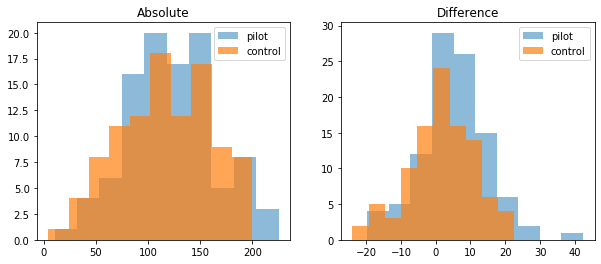

In [8]:
# отрисует на абсолютные значения просмотров и разницу просмотров по пользователям
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(df_pilot['y'], alpha=0.5, label='pilot')
ax1.hist(df_control['y'], alpha=0.7, label='control')
ax1.title.set_text('Absolute')
ax1.legend()

ax2.hist(df_pilot['y'] - df_pilot['y_before'], alpha=0.5, label='pilot')
ax2.hist(df_control['y'] - df_control['y_before'], alpha=0.7, label='control')
ax2.title.set_text('Difference')
ax2.legend()
plt.show()

In [9]:
# Воспользуемся обычным t-критерием чтобы определить уровень значимости

# проверим разницу между историческими данными, мы знаем что здесь разнице нет, AA тест
_, pvalue_prepilot = stats.ttest_ind(df_pilot['y_before'], df_control['y_before'])
# проверяем на новый данных, мы знаем что эффект есть, AB тестирование
_, pvalue_pilot = stats.ttest_ind(df_pilot['y'], df_control['y'])
print(f'pvalue prepilot {pvalue_prepilot:0.3f}')
print(f'pvalue pilot {pvalue_pilot:0.3f}')

pvalue prepilot 0.475
pvalue pilot 0.209


Как мы видим обычному критерию не хватило можности чтобы найти разницу в данных, применим CUPED

In [10]:
def calculate_theta(y_control: List[float], y_pilot: List[float],
                    y_control_cov: List[float], y_pilot_cov: List[float]) -> float:
    """
    Вычисляем Theta.
    
    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    y_control_cov - значения ковариант на контрольной группе
    y_pilot_cov - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    y_cov = np.hstack([y_control_cov, y_pilot_cov])
    covariance = np.cov(y_cov, y)[0, 1]
    variance = y_cov.var()
    theta = covariance / variance
    return theta

In [11]:
# в качестве ковариат используем целевые метрики на предыдущем периоде

theta = calculate_theta(df_control['y'], df_pilot['y'], df_control['y_before'], df_pilot['y_before'])

# для обоих групп вычислим cuped метрики
for df_ in [df_pilot, df_control]:
    df_['y_cuped'] = df_['y'] - theta * df_['y_before']

# проверим гипотезу о равенстве
_, pvalue_cuped = stats.ttest_ind(df_pilot['y_cuped'], df_control['y_cuped'])
print(f'pvalue cuped {pvalue_cuped:0.3f}')

pvalue cuped 0.014


Получили значимый эффект, посмотрим как изменились дисперсии и разница средних.

In [12]:
var_y_pilot = df_pilot['y'].var()
var_y_control = df_control['y'].var()
var_y_cuped_pilot = df_pilot['y_cuped'].var()
var_y_cuped_control = df_control['y_cuped'].var()

delta_y = df_pilot['y'].mean() - df_control['y'].mean()
delta_y_cuped = df_pilot['y_cuped'].mean() - df_control['y_cuped'].mean()

print(
    f'pilot group\n    var(y) = {var_y_pilot:0.1f}\n    var(y_cuped) = {var_y_cuped_pilot:0.1f}'
    f'\n    var(y)/var(y_cuped) = {var_y_pilot/var_y_cuped_pilot:0.2f}'
)
print(
    f'control group\n    var(y) = {var_y_control:0.1f}\n    var(y_cuped) = {var_y_cuped_control:0.1f}'
    f'\n    var(y)/var(y_cuped) = {var_y_control/var_y_cuped_control:0.2f}'
)
print(f'\ndelta_y = {delta_y:0.2f}\ndelta_y_cuped = {delta_y_cuped:0.2f}')

pilot group
    var(y) = 1842.7
    var(y_cuped) = 101.6
    var(y)/var(y_cuped) = 18.14
control group
    var(y) = 1920.2
    var(y_cuped) = 86.6
    var(y)/var(y_cuped) = 22.16

delta_y = 7.73
delta_y_cuped = 3.41


Дисперсия упала примерно в 20 раз.

Посмотрим какое значение $theta$ мы получили по теоретической формуле. Посмотрим как меняется дисперсия при других значениях.

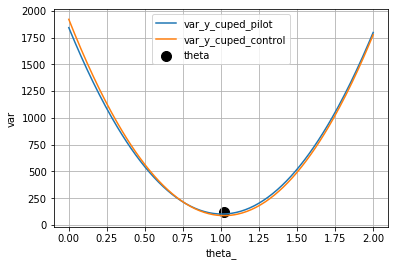

In [13]:
thetas = np.linspace(0.0, 2, 201)

list_var_y_cuped_pilot = []
list_var_y_cuped_control = []
for theta_ in thetas:
    for df_ in [df_pilot, df_control]:
        df_['y_cuped_'] = df_['y'] - theta_ * df_['y_before']
    var_y_cuped_pilot = df_pilot['y_cuped_'].var()
    var_y_cuped_control = df_control['y_cuped_'].var()
    list_var_y_cuped_pilot.append(var_y_cuped_pilot)
    list_var_y_cuped_control.append(var_y_cuped_control)

plt.plot(thetas, list_var_y_cuped_pilot, label='var_y_cuped_pilot')
plt.plot(thetas, list_var_y_cuped_control, label='var_y_cuped_control')
plt.scatter([theta], [120], label='theta', c='k', s=100)
plt.xlabel('theta_')
plt.ylabel('var')
plt.grid()
plt.legend()
plt.show()

## Задача №2

Пилот направлен на увеличение продажи минеральной воды. Продажа минеральной воды зависит от температуры воздуха на улице, чем жарче, тем продажи больше.

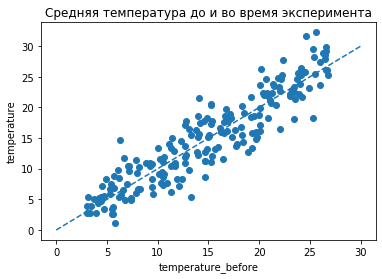

In [14]:
# сгенерируем датасет

np.random.seed(44)

group_size = 100

temperature_before = np.random.uniform(3, 27, group_size * 2)
# на основе температуры которая была сгенерируем текущую температуру
temperature = temperature_before + np.random.normal(0, 3, group_size * 2)

plt.scatter(temperature_before, temperature)
plt.plot([0, 30], [0, 30], '--')
plt.xlabel('temperature_before')
plt.ylabel('temperature')
plt.title('Средняя температура до и во время эксперимента')
plt.show()

In [15]:
# сгенерируем продажи как функцию от температуры + рандом
sales_before = (np.log(temperature_before + 40) * 100 + np.random.normal(0, 5, group_size * 2)).astype(int)
sales = (np.log(temperature + 40) * 100 + np.random.normal(0, 5, group_size * 2) ).astype(int)

df_pilot = pd.DataFrame({
    'temperature_before': temperature_before[:group_size].round(1),
    'sales_before': sales_before[:group_size],
    'temperature': temperature[:group_size].round(1),
    'sales': sales[:group_size],
})

df_control = pd.DataFrame({
    'temperature_before': temperature_before[group_size:].round(1),
    'sales_before': sales_before[group_size:],
    'temperature': temperature[group_size:].round(1),
    'sales': sales[group_size:],
})

# добавим эффект
df_pilot['sales'] += np.random.normal(3, 5, group_size).astype(int)

df_pilot.sample(5)

,temperature_before,sales_before,temperature,sales
42,24.2,424,21.8,400
58,6.2,377,8.6,393
28,16.5,396,17.7,400
47,25.3,423,29.6,406
0,23.0,413,21.8,412


Рассмотрим зависимость продаж от температуры

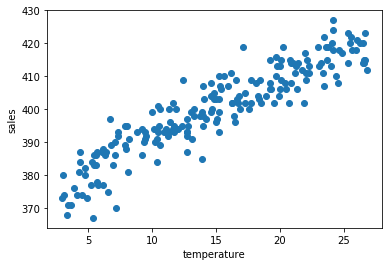

In [16]:
plt.scatter(temperature_before, sales_before)
plt.ylabel('sales')
plt.xlabel('temperature')
plt.show()

Температура выглядит как отличная ковариата: температура очевидно не зависит от нашего эксперимента и она хорошо коррелирует с целевой метрикой


Однако попробуем обойтись предыдущими подходами. Воспользуемся обычным t-test

In [17]:
delta_y = df_pilot['sales'].mean() - df_control['sales'].mean()
_, pvalue = stats.ttest_ind(df_pilot['sales'].values, df_control['sales'].values)
print(f'delta_y = {delta_y:0.2f}')
print(f'pvalue = {pvalue:0.2f}')

delta_y = 2.16
pvalue = 0.30


Попробуем воспользоваться CUPED

In [19]:
theta = calculate_theta(
    df_control['sales'].values, df_pilot['sales'].values,
    df_control['sales_before'].values, df_pilot['sales_before'].values
)

y_cuped_pilot = df_pilot['sales'].values - theta * df_pilot['sales_before'].values
y_cuped_control = df_control['sales'].values - theta * df_control['sales_before'].values

delta_y_cuped = y_cuped_pilot.mean() - y_cuped_control.mean()
_, pvalue = stats.ttest_ind(y_cuped_pilot, y_cuped_control)
print(f'delta_y_cuped = {delta_y_cuped:0.2f}')
print(f'pvalue = {pvalue:0.2f}')

delta_y_cuped = 1.32
pvalue = 0.33


Можно взять в качестве коварианты температуру воздуха на улице

In [20]:
theta = calculate_theta(
    df_control['sales'].values, df_pilot['sales'].values,
    df_control['temperature'].values, df_pilot['temperature'].values
)

y_cuped_pilot = df_pilot['sales'].values - theta * df_pilot['temperature'].values
y_cuped_control = df_control['sales'].values - theta * df_control['temperature'].values

delta_y_cuped = y_cuped_pilot.mean() - y_cuped_control.mean()
_, pvalue = stats.ttest_ind(y_cuped_pilot, y_cuped_control)
print(f'delta_y_cuped = {delta_y_cuped:0.2f}')
print(f'pvalue = {pvalue:0.2f}')

delta_y_cuped = 2.26
pvalue = 0.01


Статзначимые отличия получены!

## CUPAC

Control Using Predictions as Covariate(**CUPAC**) — немножко ML на исторических данных позволяет, не написав ни единой математической выкладки, получить новый интересный метод.

- Ошибка предсказания хорошо обученной модели временного ряда имеет нулевое мат. ожидание.
- Такое предсказание отвечает всем требованиям к ковариате в методе CUPED. Оно высоко коррелировано и независимо от эксперимента, т.к. строится на исторических данных.
- Результат предсказания применяется как ковариата в методе CUPED.

## Задача №3

Хотим протестировать влияние новых маркетинговых хитростей на стоимость продажи дома.

In [21]:
from sklearn.datasets import load_boston
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

In [23]:
boston_dataset = load_boston()
X = pd.DataFrame(boston_dataset['data'], columns=boston_dataset['feature_names'])
y = boston_dataset['target']
# добавил некоторую случайность в target
X['history'] = boston_dataset['target'] * np.random.normal(1, 0.3, boston_dataset['target'].shape[0])

In [25]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,history
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,18.180727
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,24.529819
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,37.606569
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,35.000685
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,28.395275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,9.559405
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,23.769645
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,27.441278
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,23.597589


In [26]:
# Разобьем датасет на 3 группы: A(контрольная), B(в которую добавим эффект) и обучающую(все остальное)
np.random.seed(24)

group_size = 100
indexes = np.random.choice(np.arange(len(y)), group_size * 2, False)
a_indexes = indexes[:group_size]
b_indexes = indexes[group_size:]

a_y = y[a_indexes]
b_y = y[b_indexes]

# добавим эффект
np.random.seed(33)

b_y_effect = b_y + np.random.normal(1.5, 2, len(b_y))

# выделим обучающие данные
other_indexes = np.array(list(
    set(np.arange(len(y))) - set(np.hstack([a_indexes, b_indexes]))
))
other_y = y[other_indexes]

a_X = X.iloc[a_indexes]
b_X = X.iloc[b_indexes]
other_X = X.iloc[other_indexes]

# воспользуемся t-test чтобы проверить нашу гипотезу
print(f'mean(b_y_effect) - mean(a_y) = {np.mean(b_y_effect) - np.mean(a_y):0.2f}')
print(f'pvalue = {stats.ttest_ind(a_y, b_y_effect)[1]:0.3f}')

mean(b_y_effect) - mean(a_y) = 1.60
pvalue = 0.231


Мы знаем стоимость продажи некоторых других домов. Попробуем обучить модель прогнозирования стоимости продажи дома и использовать предсказание стоимости как коварианту для CUPED.

In [29]:
# попробуем перебрать различные alpha и выбираем лучшую модель на CV, там меньше риск переобучиться
alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
model = RidgeCV(alphas=alphas, normalize=True, store_cv_values=True)
# Замечание: кроме того лучше провести отбор признаков, но это уже относиться к ML
model.fit(other_X, other_y)

a_predict = model.predict(a_X)

print(f'MSE model predict: {mean_squared_error(a_y, a_predict):0.1f}')
# строим наивный прогноз как просто средний target по обучающей выборке
print(f'MSE naive predict: {mean_squared_error(a_y, np.zeros(len(a_y)) + np.mean(other_y)):0.1f}')

print(f'corr(a_y, a_predict) = {np.corrcoef(a_y, a_predict)[0, 1]:0.3f}')

MSE model predict: 20.0
MSE naive predict: 68.0
corr(a_y, a_predict) = 0.839


Видим, что качество предсказание модели лучше безлайна. Корреляция довольно большая. Применим CUPED.

In [31]:
a_predict = model.predict(a_X)
b_predict = model.predict(b_X)

theta = calculate_theta(
    a_y, b_y_effect,
    a_predict, b_predict
)

y_cuped_pilot = b_y_effect - theta * b_predict
y_cuped_control = a_y - theta * a_predict

delta_y_cuped = y_cuped_pilot.mean() - y_cuped_control.mean()
_, pvalue = stats.ttest_ind(y_cuped_pilot, y_cuped_control)
print(f'delta_y_cuped = {delta_y_cuped:0.2f}')
print(f'pvalue = {pvalue:0.3f}')

delta_y_cuped = 1.39
pvalue = 0.025


Получили стат значимые отличия!

Проверим данный метод на корректность. Для этого можно сгенерировать множество датасетов в которых нет различия, в таком случае распредление p_value на тестах должно быть равномерным

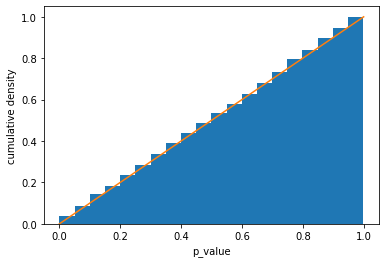

In [35]:
# объединяем A и B группы
yy = np.hstack([y_cuped_pilot, y_cuped_control])

pvalue_distribution  = []

for _ in range(1000):
    # случайно перемешиваем и делим на A и B
    # в этих группах нет различия
    np.random.shuffle(yy)
    a_ = yy[:100]
    b_ = yy[100:]
    _, pvalue = stats.ttest_ind(a_, b_)
    pvalue_distribution.append(pvalue)

plt.hist(pvalue_distribution, bins=20, cumulative=True, density=True)
plt.xlabel('p_value')
plt.ylabel('cumulative density')
plt.plot([0,1], [0,1]);

# Проверки статистических критериев 

Во время проведения A/B тестирования возникает вопрос какое критерий лучше использовать и можно ли какой-то конкретные критерий использовать вообще. Ведь использование критерия в неподходящих условиях может привести к неверным выводам. Допустим мы хотим использовать t-test, он гарантирует правильность результатов, при условии выполнения центральной предельной теоремы. Возникает вопрос насколько наши данные подпадают под действие ЦПТ. Поэтому стоит проверить корректность критерия перед тем как его использовать. 

Алгоритм проверки:

1. Создаём множество датасетов, поделённых на контроль и тест, без какого-либо различия между ними (обычный А/А-тест), а также датасеты между которыми есть различие(A/B тест).
2. Прогоняем на них выбранный критерий и считаем ошибки первого и второго рода
3. Если мы хотим, чтобы ошибка первого рода была 5%, то критерий должен ошибиться на этих примерах лишь в 5% случаев. Если ошибка составляет больше 5% случаев, то следует что критерий некорректен.
4. Среди критериев которые прошли проверку(на ошибку первого рода) выбирается критерий с самой большой мощностью(то есть с наименьшей ошибкой второго рода)

**Замечание**: так как оценка ошибки первого рода будет не ровно $\alpha$ то нужно сделать тест(или построить доверительный интервал) что она равно именно $\alpha$

**Замечание**: для тестирования построения доверительного интервала алгоритм аналогичный, с единственной разницей что на каждом шаге проверяется что истинная разница лежит в доверительном интервале в $1-\alpha$ случаев. И выбирается тот алгоритм, который дает наименьшую длину интервала.

 Возникает вопрос откуда брать данные, есть 2 выхода:

1. Создать датасеты полностью на синтетических данных.
2. Создать датасеты, основываясь на исторических данных.

## Синтетические данные

Исходя из природы данные можно предположить его распределение. Кроме того можно подробнее рассмотреть данные и выделить отдельные группы и для каждой группы генерировать данные отдельно друг от друга, таким образом получить смесь распределений и так далее. 

Главные плюсы синтетических данных в том, что их сколько угодно, можно создать очень точно оценить ошибку первого рода вашего критерия. Кроме того на начальных  этапах дебага нового критерия искусственные данные сильно лучше реальных. Главный минус — вы получили корректность вашего критерия только на искусственных данных. И качество на реальных данных может сильно отличаться в зависимости от качества синтетики.

Отличный пример по генерации датасетов от VK([link](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#1e3b))


## Пример 

Допустим что мы проводим A/B тест для выручки магазина, тогда это можно симулировать с помощью экспоненциального распределения(то есть как правило клиенты совершают маленькие покупки и реже крупные) и для этого хотим проверить t-test

In [442]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
from typing import List, Tuple
from statsmodels.stats.proportion import proportion_confint

In [443]:
# простой генератор данных
def simple_expon_generator(size: int = 1000, scale: float = 700, effect: float = 0):
    samples = stats.expon(scale=scale + effect).rvs(size)
    return samples

In [444]:
# Цикл проверки.
N = 10000  # количество тестов
effect = 50  # размер эффекта которое хотим детектировать(для A/B тестирования)
alpha = 0.05
first_type_error = 0  # счетчик ошибок первого рода
second_type_error = 0  # счетчик ошибок второго рода
p_values_H0 = []  # выпишем отдельно все p_value соответствующие A/A тесту
p_values_H1 = []  # выпишем отдельно все p_value соответствующие A/B тесту
for i in tqdm(range(N)):
    A_group = simple_expon_generator()
    A2_group = simple_expon_generator()
    B_group = simple_expon_generator(effect=effect)
    statistic, p_value = stats.ttest_ind(A_group, A2_group, equal_var=False)  # A/A тест
    p_values_H0.append(p_value)
    if p_value < alpha:
        first_type_error += 1
    statistic, p_value = stats.ttest_ind(A_group, B_group, equal_var=False)  # A/B тест
    p_values_H1.append(p_value)
    if p_value > alpha:
        second_type_error += 1
# строим доверительный интервал для количества ошибок первого рода
first_error_interval = proportion_confint(first_type_error, N, method = 'normal')
# проверяем коррекность критерия
correctness = first_error_interval[0] < alpha < first_error_interval[1]
print('correctness:', correctness)
print('first_type_error:', first_type_error)
print('first_type_error ratio:', first_type_error/N)
print('first_error_interval:', np.round(first_error_interval, 3))
print('second_type_error:', second_type_error)
print('second_type_error ratio:', second_type_error/N)


correctness: True
first_type_error: 526
first_type_error ratio: 0.0526
first_error_interval: [0.048 0.057]
second_type_error: 6533
second_type_error ratio: 0.6533


Как видим, даже несмотря на то что данные не распределены нормально t-test работает корректно!

In [445]:
def show_p_value_cdf(p_values: List[float], hypothesis: str,
                     alpha: float = 0.05, figsize: Tuple[int, int] = (20, 6)) -> None:
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.hist(p_values)
    plt.xlabel('p_value')
    plt.title(f'p_value distribution under {hypothesis}')
    plt.subplot(1, 2, 2)
    plt.plot(sorted(p_values), np.linspace(0, 1, len(p_values)), label='p_value')
    plt.title(f'p_value CDF under {hypothesis}')
    plt.xlabel('p_value')
    plt.axvline(alpha, color='red', label='alpha')
    plt.legend()
    plt.show()

Можно также рассмотреть распредление p_value для каждой из гипотез, а также график кумулятивной функции плотности(CDF).

Для H_0 все гипотезы верны по построению и поэтому можно ожидать что распределение p_value будет равномерным. p_value будет верно управлять вероятностью ошибки первого рода в случае если значение p_value будет соответствовать кумулятивной плотности распределения в этой точке. Иначе говоря для верного критерия должна получиться диагональная линия.

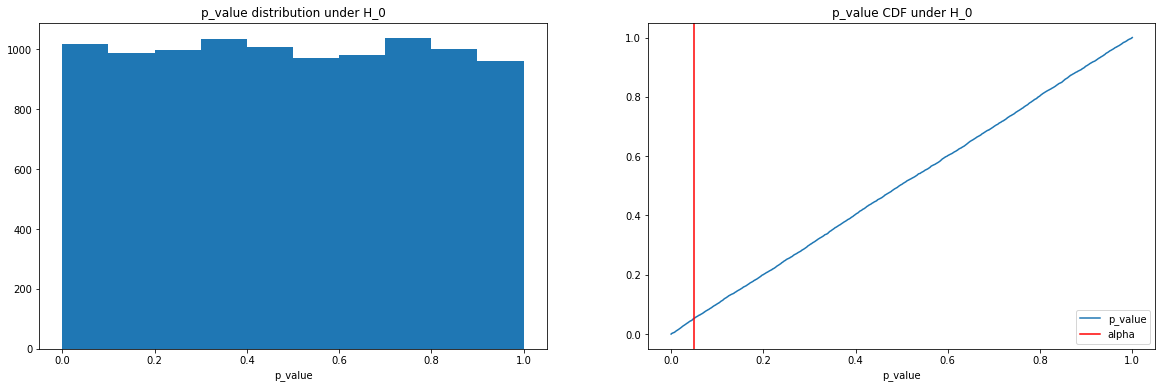

In [446]:
show_p_value_cdf(p_values_H0, 'H_0')

Аналогично построим графики для гипотизы $H_1$. В этом случае видно что большая часть площади сосредоточена в районе 0, что логично учитывая что гипотеза H_0 не верна в этом случае. 

На графике кумулятивной функции плотности точка p_value=alpha соответствует можности нашего критерия(при фиксированном размере эффекта и размера выборки). Иначе говоря этот график(при коррекности критерия) показывает trade-off между ошибками первого и второго рода

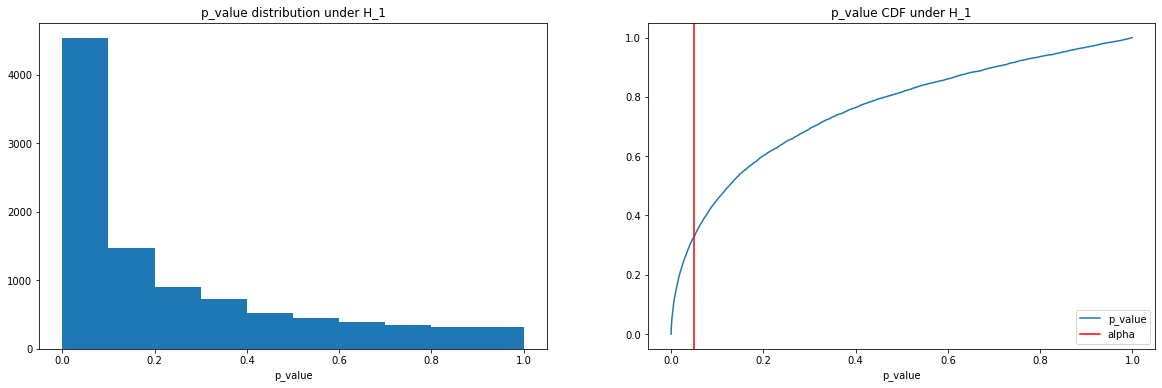

In [347]:
show_p_value_cdf(p_values_H1, 'H_1')

## Пример

При этом часто можно если посмотреть на данные более сложные синтетические данные. Так например, можно принять за внимание что скорее всего в группах A и B будет не одинаковое количество данных или что оно может быть в некотором диапозоне. Можно обнонаружить что разные пользователи лучше описываются разными распределниями и тем самым сделать более качественную синтетику. 

Например для нашего примера можно взять за внимание что:

- в каждой группе будет от 800 до 1200 элементов. 
- Можно выделить группу пользователей(например детей), которые делают больше мелкие покупки и редко покупают на большую сумму, это можно симулировать экспоненциальным распределением
- Можно выделить группу пользователей(например замужних женщи), которые делают покупки как правило на всю семью и реже делают мелкие покупки, можно воспользоваться логнормальным распределением для этого
- Можно выделить группу людей которые как правило делают "средние" покупки, можно воспользоваться нормальным распределением

Как видно итоговое распрделение будет смесью множества распределний. Понятно что для такого распрделения не будет твердого теоретического обоснования каким кримерием пользоваться.

In [141]:
def complicated_expon_generator(size_bounds=[800, 1200],
                                weights=[0.1, 0.4, 0.5], effect=0):
    strat_params=[{'scale': 200 + effect},
                  {'s': 0.4, 'scale': 1000 + effect},
                  {'scale': 10, 'loc': 500 + effect}]
    assert len(strat_params) == len(weights)
    n_strat = len(strat_params)
    samples = np.array([])
    # определяем размер выборки
    size = np.random.randint(size_bounds[0], size_bounds[1])
    # для каждого элемента определяем его тип
    sample_types = np.random.choice(n_strat, p=weights, size=size)
    # генерируем данные для каждой группы
    strat_size = np.sum(sample_types == 0)
    samples = np.append(n_strat, stats.expon(**strat_params[0]).rvs(strat_size))
    
    strat_size = np.sum(sample_types == 1)
    samples = np.append(samples, stats.lognorm(**strat_params[1]).rvs(strat_size))
    
    strat_size = np.sum(sample_types == 2)
    samples = np.append(samples, stats.norm(**strat_params[2]).rvs(strat_size))
    samples = np.clip(samples, 0, None)  # так как нормальные может генерировать числа меньше 0
    
    np.random.shuffle(samples)
    return samples

In [143]:
# Цикл проверки.
N = 1000  # количество тестов
effect = 50  # размер эффекта которое хотим детектировать(для A/B тестирования)
alpha = 0.05
first_type_error = 0  # счетчик ошибок первого рода
second_type_error = 0  # счетчик ошибок второго рода
for i in tqdm(range(N)):
    A_group = complicated_expon_generator()
    A2_group = complicated_expon_generator()
    B_group = complicated_expon_generator(effect=effect)
    statistic, p_value = stats.ttest_ind(A_group, A2_group, equal_var=False)  # A/A тест
    if p_value < alpha:
        first_type_error += 1
    statistic, p_value = stats.ttest_ind(A_group, B_group, equal_var=False)  # A/B тест
    if p_value > alpha:
        second_type_error += 1
# строим доверительный интервал для количества ошибок первого рода
first_error_interval = proportion_confint(first_type_error, N, method = 'normal')
# проверяем коррекность критерия
correctness = first_error_interval[0] < alpha < first_error_interval[1]
print('correctness:', correctness)
print('first_type_error:', first_type_error)
print('first_type_error ratio:', first_type_error/N)
print('first_error_interval:', np.round(first_error_interval, 3))
print('second_type_error:', second_type_error)
print('second_type_error ratio:', second_type_error/N)


correctness: True
first_type_error: 53
first_type_error ratio: 0.053
first_error_interval: [0.039 0.067]
second_type_error: 275
second_type_error ratio: 0.275


## Реальные данные

Если есть много исторических данных то можно их разделить на много маленьких датасетов(например сгруппировав их по городам/типам и так далее, см пример([link](https://habr.com/ru/company/avito/blog/571094/))), разделить каждый датасет на 2 группы и провести множество A/A тестов

Самый простой способ это  провести честный A/A тест и по нему можно сгенерировать бесконечное количество A/A-тестов, случайным образом разделив пользователей на две группы. И таким образом проверить критерий на ошибку первого рода.

Для генерации A/B тестов можно попробовать в одну из групп(описанных выше) добавлять некоторый эффект, например можно значения в одной из выборок умножать на константу, добавлять константу или реализовать более сложные механики, имитирующие влияние эксперимента на пользователей.

## Пример

Допустим у нас есть исторические данные некоторой системы(продажи в магазине например) или проведен A/A тест. Исходя из этих реальных данных хочется понять какой критерий можно использовать в этой задаче

In [391]:
import pandas as pd
from typing import Tuple, Callable
from datetime import datetime, timedelta
from functools import partial

In [392]:
pseudo_aa_data = pd.read_csv('./data/pseudo_aa_data.scv')
pseudo_aa_data.head()

,time,value,group
0,2024-12-06 15:29:43.079060,513.947825,A
1,2024-12-06 19:43:10.079060,482.569352,A
2,2024-12-06 19:43:04.079060,84.785151,A
3,2024-12-06 19:43:04.079060,514.378738,A
4,2024-12-06 19:43:06.079060,495.243672,B


Сделаем генератор, которые будет случайно разделять данные на A/B таким образом можно получить практически бесконечное количестов датасетов под A/A тест(так как реально данные из одного распределния)

In [393]:
def real_data_generator(dataset_values: np.ndarray, effect_size: float = 0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Генерирует данные на основе определенного датасета
    """
    a_indexes = np.random.randint(0, 2, size=len(dataset_values))
    b_indexes = 1 - a_indexes
    a_values = dataset_values[np.where(a_indexes==1)]
    b_values = dataset_values[np.where(b_indexes==1)]
    if effect_size > 0:
        b_values += np.random.normal(effect, scale=8, size=np.sum(b_indexes))
    return a_values, b_values

Теперь можно просто запустить каждый критерий на полученных данных и проверить его ошибки первого и второго рода

In [397]:
def criterion_check(criterion: Callable[[Tuple[np.ndarray, np.ndarray]], Tuple[float, float]],
                    N: int = 10000, effect: float = 50, alpha: float = 0.05) -> None:
    """
    Вычисляет ошибки первого и второго рода для статистического критерия
    """
    first_type_error = 0  # счетчик ошибок первого рода
    second_type_error = 0  # счетчик ошибок второго рода
    for i in tqdm(range(N)):
        a_values, b_values = real_data_generator(pseudo_aa_data['value'].values)
        statistic, p_value = criterion(a_values, b_values)  # A/A тест
        if p_value < alpha:
            first_type_error += 1
        a_values, b_values = real_data_generator(pseudo_aa_data['value'].values, effect_size=effect)
        statistic, p_value = criterion(a_values, b_values)  # A/B тест
        if p_value > alpha:
            second_type_error += 1
    # строим доверительный интервал для количества ошибок первого рода
    first_error_interval = proportion_confint(first_type_error, N, method = 'normal')
    # проверяем коррекность критерия
    correctness = first_error_interval[0] < alpha < first_error_interval[1]
    print('correctness:', correctness)
    print('first_type_error:', first_type_error)
    print('first_type_error ratio:', first_type_error/N)
    print('first_error_interval:', np.round(first_error_interval, 3))
    print('second_type_error:', second_type_error)
    print('second_type_error ratio:', second_type_error/N)

In [398]:
ttest = stats.ttest_ind
welch_ttest = partial(stats.ttest_ind, equal_var=False)
print('ttest')
criterion_check(ttest)
print('=' * 20)
print('welch_ttest')
criterion_check(welch_ttest)

ttest



correctness: True
first_type_error: 497
first_type_error ratio: 0.0497
first_error_interval: [0.045 0.054]
second_type_error: 5980
second_type_error ratio: 0.598
welch_ttest



correctness: True
first_type_error: 517
first_type_error ratio: 0.0517
first_error_interval: [0.047 0.056]
second_type_error: 5804
second_type_error ratio: 0.5804


Когда критерий выбран, то можно воспользоваться им для того чтобы проверить нашу гипотезу уже на реальном A/B выборке

In [399]:
pseudo_ab_data = pd.read_csv('./data/pseudo_ab_data.scv')

In [400]:
a_values = pseudo_ab_data[pseudo_ab_data['group'] == 'A']['value']
b_values = pseudo_ab_data[pseudo_ab_data['group'] == 'B']['value']
statistic, p_value = welch_ttest(a_values, b_values)
print('p_value:', p_value)

p_value: 0.0011886447582843053


Гипотеза отвергнута!

# Стратификация выборки

Допустим мы проводим A/B тестирование и разлепили пользователей на 2 группы. При этом пользователи сильно отличаются друг от друга, например в одной группе намного больше мужчин, а в другой женщин. И позже разница между значениями метрики между группа будет больше зависеть не от нашего изменения, а от распределения пользователей в группах. Это вносит дополнительный шум в эксперимент. 

<img src="images/possible_splits_in_regular_AB_testing.png"  width="600px" title="aaa">

**Ковариата** - метрика, которая коррелирует с целевой метрикой, может быть измерена до эксперимента (строго говоря, нет) и не зависит от других экспериментов. Примеры: пол, возраст, город проживания, операционная система устройства пользователя

С помощью ковариат можно разделить популяцию на непересекающиеся подмножества, которые будут обладать уникальным набором значений ковариат. Такие подмножества называются **стратами**.

После этого можно семплировать данные на A/B уже из этих страт.

__Замечание__: нужно умнеть ввиду что при стратификации обе группы будут выровнены только по тем признакам что мы отобрали и возможно какой-то неучтенный признак влияет больше чем выбранные. 

<img src="images/splitting_in_AB-testing_with_stratification.png"  width="600px" title="aaa">

Для лучшего понимания выпишем оценки среднего 

$\hat{X}_{srs} = \frac{1}{n}\sum_{k=1}^K\sum_{j=1}^{n_k}X_{kj}$ 

$\hat{X}_{strat} = \sum_{k=1}^K w_k\hat{X}_k$ , где $\hat{X}_{k} = \frac{1}{n_k}\sum_{j=1}^{n_k}X_{kj}$, а $w_k$ - вес страты на генеральной совокупности

Конечно $\hat{X}_{srs} =\hat{X}_{strat}$ и их матожидания так же равны. Однако дисперсии у них разные

$\mathbb{D}\hat{X}_{strat} = \frac{1}{n}\sum_{k=1}^Kw_k\sigma_{k}^2$, где  $\sigma_{k}^2$ -  дисперсия метрики в соответствующей страте

$\mathbb{D}\hat{X}_{srs} = \frac{1}{n}\sum_{k=1}^Kw_k\sigma_{k}^2 + \frac{1}{n}\sum_{k=1}^Kw_k(\mu_k - \mu)^2$

Следовательно чем более различаются страты между собой тем больше стратификация уменьшит дисперсию оценки среднего. Это в свою очередь увеличит чувствительность критерия.

Если воспользоваться стратификацией и после применить стандартный критерий стьюдента

$t=\dfrac{\hat{X}_B - \hat{X}_A}{\sqrt{\hat{\sigma}_B^2 + \hat{\sigma}_B^2 }}$

 то он даст заниженную вероятность ошибки первого рода. Так как он ничего не знает про стратификации и использует завышенную оценку дисперсии. Чтобы исправить это нужно использовать стратифицированное среднее и оценку дисперсии, причем веса страт определяются по генеральной совокупности. 

$t=\dfrac{\hat{X}_{strat, B} - \hat{X}_{strat, A}}{\sqrt{\hat{\sigma}_{strat,A}^2 + \hat{\sigma}_{strat, B}^2 }}$

При этом не всегда возможно заранее разделить выборку на A/B тестирование по стратам. Однако в этом случае можно постфактум разделить выборку на страты и использовать уже модифицированные критерий(учитывающий стратификацию).  Такой подход называется **постстратификацией.** Это также даст прирост, причем на больших выборках разница с обыность стратификацией незначительная.

Таким образом, можно выделить несколько способов:

1. составления групп
    1. случайное;
    2. стратифицированное.
2. оценки среднего
    1. выборочное среднее
    2. стратифицированное среднее.

Более того, их можно комбинировать в различных сценариях.

<img src="images/types_of_stratification_approach.png"  width="600px" title="aaa">


In [401]:
import pandas as pd
from tqdm.notebook import tqdm
from scipy import stats
import numpy as np

In [11]:
def get_stratified_data(strat_to_param, effect=0):
    """Генерирует данные стратифицированным семплированием.

    Возвращает датафрейм со значениями метрики и страт пользователей
    в контрольной и экспериментальной группах.

    strat_to_param - словарь с параметрами страт
    effect - размер эффекта
    """
    control, pilot = [], []
    for strat, (n, mu, std) in strat_to_param.items():
        control += [
            (x, strat,) for x in np.random.normal(mu, std, n)
        ]
        pilot += [
            (x, strat,) for x in np.random.normal(mu + effect, std, n)
        ]
    columns = ['value', 'strat']
    control_df = pd.DataFrame(control, columns=columns)
    pilot_df = pd.DataFrame(pilot, columns=columns)
    return control_df, pilot_df
 
def get_random_data(strats, sample_size, strat_to_param, effect=0):
    """Генерирует данные случайным семплированием.

    Возвращает датафрейм со значениями метрики и страт пользователей
    в контрольной и экспериментальной группах.

    strats - cписок страт в популяции
    sample_size - размеры групп
    strat_to_param - словарь с параметрами страт
    effect - размер эффекта
    """
    control_strats, pilot_strats = np.random.choice(
        strats, (2, sample_size), False
    )
    control, pilot = [], []
    for strat, (n, mu, std) in strat_to_param.items():
        n_control_ = np.sum(control_strats == strat)
        control += [
            (x, strat,) for x in np.random.normal(mu, std, n_control_)
        ]
        n_pilot_ = np.sum(pilot_strats == strat)
        pilot += [
            (x, strat,) for x in np.random.normal(mu + effect, std, n_pilot_)
        ]
    columns = ['value', 'strat']
    control_df = pd.DataFrame(control, columns=columns)
    pilot_df = pd.DataFrame(pilot, columns=columns)
    return control_df, pilot_df


def ttest(a: pd.DataFrame, b: pd.DataFrame) -> float:
    """Возвращает pvalue теста Стьюдента.
  
    a, b - данные пользователей контрольной и экспериментальной групп
    """
    _, pvalue = stats.ttest_ind(a['value'].values, b['value'].values)
    return pvalue

In [5]:
alpha = 0.05                        # уровень значимости
N = 10000                           # количество пользователей в популяции
w_one, w_two = 0.5, 0.5             # доли страт в популяции
N_one = int(N * w_one)              # количество пользователей первой страты
N_two = int(N * w_two)              # количество пользователей второй страты
mu_one, mu_two = 2000, 3000         # средние выручки в стратах
std_one, std_two = 625, 625         # стандартное отклонение в стратах

# список страт в популяции
strats = [1 for _ in range(N_one)] + [2 for _ in range(N_two)]

# размер групп эксперимента
sample_size = 1100
sample_size_one = int(sample_size * w_one)
sample_size_two = int(sample_size * w_two)

# маппинг параметров страт
strat_to_param = {
    1: (sample_size_one, mu_one, std_one,),
    2: (sample_size_two, mu_two, std_two,)
}

random_first_type_errors = []
stratified_first_type_errors = []
random_deltas = []
stratified_deltas = []

for _ in tqdm(range(10000)):
#     print(_)
    control_random, pilot_random = get_random_data(
        strats, sample_size, strat_to_param
    )
    control_stratified, pilot_stratified = get_stratified_data(
        strat_to_param
    )
    random_deltas.append(
        pilot_random['value'].mean() - control_random['value'].mean()
    )
    stratified_deltas.append(
        pilot_stratified['value'].mean() - control_stratified['value'].mean()
    )

    pvalue_random = ttest(control_random, pilot_random)
    random_first_type_errors.append(pvalue_random < alpha)
    pvalue_stratified = ttest(control_stratified, pilot_stratified)
    stratified_first_type_errors.append(pvalue_stratified < alpha)
 
part_random_first_type_errors = np.mean(random_first_type_errors)
part_stratified_first_type_errors = np.mean(stratified_first_type_errors)
print(f'part_random_first_type_errors = {part_random_first_type_errors:0.3f}')
print(f'part_stratified_first_type_errors = {part_stratified_first_type_errors:0.3f}')


part_random_first_type_errors = 0.048
part_stratified_first_type_errors = 0.011


Стратифицированное семплирование снизило вероятность ошибки первого рода более чем в 4 раза!

С одной стороны, уменьшить вероятность ошибки первого рода - это хорошо, так как позволит чаще принимать верные решения. С другой стороны, сильное отличие вероятности ошибки первого рода от заданного уровня значимости - это плохо, так как это не тот тест, который мы хотели построить.

/Users/v.s.dokholyan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/v.s.dokholyan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/v.s.dokholyan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


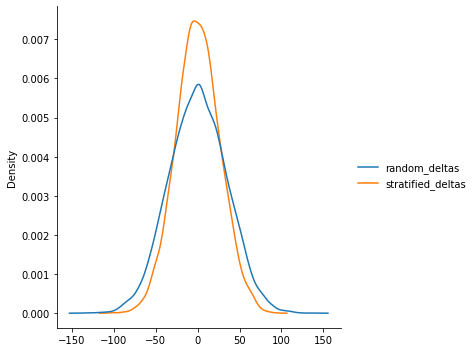

In [10]:
import seaborn as sns

sns.displot(
    {'random_deltas': random_deltas, 'stratified_deltas': stratified_deltas},
    kind='kde'
)

Распределение разницы средних при стратифицированном семплировании имеет менее тяжёлые хвосты и соответственно меньшую дисперсию, что и приводит к уменьшению количества ошибок первого рода.

Оценим вероятности ошибок второго рода, искусственно добавив эффект к экспериментальной группе.

In [13]:
effect = 100
random_second_type_errors = []
stratified_second_type_errors = []

for _ in tqdm(range(10000)):
    control_random, pilot_random = get_random_data(
        strats, sample_size, strat_to_param, effect
    )
    control_stratified, pilot_stratified = get_stratified_data(
        strat_to_param, effect
    )
    pvalue_random = ttest(control_random, pilot_random)
    random_second_type_errors.append(pvalue_random >= alpha)
    pvalue_stratified = ttest(control_stratified, pilot_stratified)
    stratified_second_type_errors.append(pvalue_stratified >= alpha)
 
part_random_second_type_errors = np.mean(random_second_type_errors)
part_stratified_second_type_errors = np.mean(stratified_second_type_errors)
print(f'part_random_second_type_errors = {part_random_second_type_errors:0.3f}')
print(f'part_stratified_second_type_errors = {part_stratified_second_type_errors:0.3f}')


part_random_second_type_errors = 0.163
part_stratified_second_type_errors = 0.108


Стратифицированное семплирование уменьшило долю ошибок второго рода примерно в полтора раза!


Стратифицированное семплирование позволило уменьшить вероятности ошибок I и II рода, это очень хорошо. Но мы получили не совсем тот тест, который хотели изначально. Мы хотели проверять гипотезы на уровне значимости 0.05, а получается что проверяем на более низком уровне значимости. Так происходит из-за того, что при стратифицированном семплировании мы не только делаем распределение средних более узким, но и снижаем дисперсию, зафиксировав количество страт в каждой группе. Тест Стьюдента не знает о том, что мы семплируем данные не случайно, поэтому при подсчёте статистики используется завышенная оценка дисперсии. Вернуть тест на нужный уровень значимости нам поможет стратифицированное среднее.

In [16]:
def calc_strat_mean(df: pd.DataFrame, weights: pd.Series) -> float:
    """Считает стратифицированное среднее.

    df - датафрейм с целевой метрикой и данными для стратификации
    weights - маппинг {название страты: вес страты в популяции}
    """
    strat_mean = df.groupby('strat')['value'].mean()
    return (strat_mean * weights).sum()


def calc_strat_var(df: pd.DataFrame, weights: pd.Series) -> float:
    """Считает стратифицированную дисперсию.
    df - датафрейм с целевой метрикой и данными для стратификации
    weights - маппинг {название страты: вес страты в популяции}
    """
    strat_var = df.groupby('strat')['value'].var()
    return (strat_var * weights).sum()


def ttest_strat(a: pd.DataFrame, b: pd.DataFrame, weights: pd.Series) -> float:
    """Возвращает pvalue теста Стьюдента для стратифицированного среднего.

    a, b - данные пользователей контрольной и экспериментальной групп
    weights - маппинг {название страты: вес страты в популяции}
    """
    a_strat_mean = calc_strat_mean(a, weights)
    b_strat_mean = calc_strat_mean(b, weights)
    a_strat_var = calc_strat_var(a, weights)
    b_strat_var = calc_strat_var(b, weights)
    delta = b_strat_mean - a_strat_mean
    std = (a_strat_var / len(a) + b_strat_var / len(b)) ** 0.5
    t = delta / std
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(t)))
    return pvalue


weights = pd.Series({1: w_one, 2: w_two})

first_type_errors = []
second_type_errors = []

for _ in tqdm(range(10000)):
    control_aa, pilot_aa = get_stratified_data(
        strat_to_param
    )
    control_ab, pilot_ab = get_stratified_data(
        strat_to_param, effect
    )

    pvalue_aa = ttest_strat(control_aa, pilot_aa, weights)
    first_type_errors.append(pvalue_aa < alpha)
    pvalue_ab = ttest_strat(control_ab, pilot_ab, weights)
    second_type_errors.append(pvalue_ab >= alpha)


part_first_type_errors = np.mean(first_type_errors)
part_second_type_errors = np.mean(second_type_errors)
print(f'part_first_type_errors = {part_first_type_errors:0.3f}')
print(f'part_second_type_errors = {part_second_type_errors:0.3f}')


part_first_type_errors = 0.051
part_second_type_errors = 0.034


Получаем долю ошибок I рода 0.05 и ошибок II рода 0.035. Теперь тест контролируют вероятность ошибки первого рода на заданном уровне значимости, но при этом его мощность значительно увеличилась.

Проверим, что постстратификация тоже увеличивает чувствительность теста. Повторим последний эксперимент, заменив стратифицированное семплирование на случайное семплирование.

In [17]:
first_type_errors = []
second_type_errors = []


for _ in tqdm(range(10000)):
    control_aa, pilot_aa = get_random_data(
        strats, sample_size, strat_to_param
    )
    control_ab, pilot_ab = get_random_data(
        strats, sample_size, strat_to_param, effect
    )

    pvalue_aa = ttest_strat(control_aa, pilot_aa, weights)
    first_type_errors.append(pvalue_aa < alpha)
    pvalue_ab = ttest_strat(control_ab, pilot_ab, weights)
    second_type_errors.append(pvalue_ab >= alpha)


part_first_type_errors = np.mean(first_type_errors)
part_second_type_errors = np.mean(second_type_errors)
print(f'part_first_type_errors = {part_first_type_errors:0.3f}')
print(f'part_second_type_errors = {part_second_type_errors:0.3f}')


part_first_type_errors = 0.049
part_second_type_errors = 0.035


Итак постстратификация также увеличивает чувствительность критерия. При этом на больших выборках разница с обыность стратификацией незначительная.

# Bootstrap и проверка гипотез

In [56]:
import scipy 
import numpy as np
from scipy import stats
from typing import List
from tqdm.notebook import tqdm

In [60]:
dataset_a = simple_expon_generator(size=1000)
dataset_a2 = simple_expon_generator(size=900)
dataset_b = simple_expon_generator(effect=10000)

In [63]:
def _calculate_t_stat(dataset_a: List[float], dataset_b: List[float]) -> float:
    size_a = len(dataset_a)
    size_b = len(dataset_b)
    dataset_a = np.array(dataset_a)
    dataset_b = np.array(dataset_b)
    mean_a = dataset_a.mean()
    mean_b = dataset_b.mean()
    std_a = dataset_a.std(ddof=1)
    std_b = dataset_b.std(ddof=1)
    t_stat = (mean_a - mean_b) / np.sqrt(std_a **2 / size_a + std_b ** 2 / size_b)
    return t_stat

def bootstrap_test_iid(dataset_a: List[float], dataset_b: List[float], B: int = 1000) -> float:
    """
    H_0: среднии двух выборках равны, H_1: dataset_a.mean() > dataset_b.mean()
    """
    size_a = len(dataset_a)
    size_b = len(dataset_b)
    dataset_a = np.array(dataset_a)
#     print('dataset_a std:', dataset_a.std())
    dataset_b = np.array(dataset_b)
    mean_a = dataset_a.mean()
    mean_b = dataset_b.mean()
    union_mean = mean_a * size_a / (size_a + size_b) + mean_b * size_b / (size_a + size_b)
#     print('union_mean:', union_mean)
    t_stat = _calculate_t_stat(dataset_a, dataset_b)
#     print(t_stat)
    
    dataset_a2 = dataset_a - mean_a + union_mean
#     print('dataset_a2 std:', dataset_a.std())
    dataset_b2 = dataset_b - mean_b + union_mean
    dataset_a2_bootstrap = np.random.choice(dataset_a2, size=(B, size_a))
    dataset_b2_bootstrap = np.random.choice(dataset_b2, size=(B, size_b))
    t_stat_bootstrap = []
    for idx in range(B):
        t_stat_boot = _calculate_t_stat(dataset_a2_bootstrap[idx], dataset_b2_bootstrap[idx])
        t_stat_bootstrap.append(t_stat_boot)
    t_stat_bootstrap = np.array(t_stat_bootstrap)
#     print(t_stat_bootstrap.mean(), t_stat_bootstrap.std())
    total = np.sum(t_stat_bootstrap > t_stat)
    p_value = total / B
    return p_value

In [62]:
dataset_a = scipy.stats.norm(loc=0, scale=6).rvs(100)
dataset_b = scipy.stats.norm(loc=1, scale=6).rvs(100)

N = 1000
first_type_error = 0
secon_type_error = 0
alpha = 0.05
for _ in tqdm(range(N)):
#     dataset_a = scipy.stats.norm(loc=0, scale=6).rvs(100)
#     dataset_a2 = scipy.stats.norm(loc=0, scale=6).rvs(100)
#     dataset_b = scipy.stats.norm(loc=1, scale=6).rvs(100)
    dataset_a = simple_expon_generator(size=500)
    dataset_a2 = simple_expon_generator(size=500)
    dataset_b = simple_expon_generator(size=500, effect=100)
#     p_value = stats.ttest_ind(dataset_a2, dataset_a, alternative='greater')[1]
    p_value = bootstrap_test_iid(dataset_a2, dataset_a)
    if p_value < alpha:
        first_type_error += 1
#     p_value = stats.ttest_ind(dataset_b, dataset_a, alternative='greater')[1]
    p_value = bootstrap_test_iid(dataset_b, dataset_a)
    if p_value > alpha:
        secon_type_error += 1
        
print(first_type_error / N)
print(secon_type_error / N)


0.05
0.304


In [309]:
stats.ttest_ind(dataset_b, dataset_a, alternative='greater')[1]

0.278555683694348

In [264]:
dataset_a = scipy.stats.norm(loc=0, scale=1).rvs(1000)
dataset_b = scipy.stats.norm(loc=0, scale=1).rvs(1000)
size_a = len(dataset_a)
size_b = len(dataset_b)
B = 1000

In [266]:
dataset_a_bootstrap = np.random.choice(dataset_a, size=(B, int(size_a * 0.8)))
dataset_b_bootstrap = np.random.choice(dataset_b, size=(B, int(size_b * 0.8)))

In [267]:
p_value_list = []
for idx in range(B):
#     dataset_a = scipy.stats.norm(loc=0, scale=1).rvs(1000)
#     dataset_b = scipy.stats.norm(loc=0, scale=1).rvs(1000)
    p_value = stats.ttest_ind(dataset_a_bootstrap[idx], dataset_b_bootstrap[idx])[1]
#     p_value = stats.ttest_ind(dataset_a, dataset_b)[1]
    p_value_list.append(p_value)

In [268]:
p_value_list = np.array(p_value_list)

In [269]:
np.mean(p_value_list < 0.05)

0.286

(array([401., 145., 102.,  69.,  51.,  59.,  46.,  42.,  39.,  46.]),
 array([1.37690757e-05, 9.99780214e-02, 1.99942274e-01, 2.99906526e-01,
        3.99870779e-01, 4.99835031e-01, 5.99799283e-01, 6.99763536e-01,
        7.99727788e-01, 8.99692040e-01, 9.99656293e-01]),
 <a list of 10 Patch objects>)

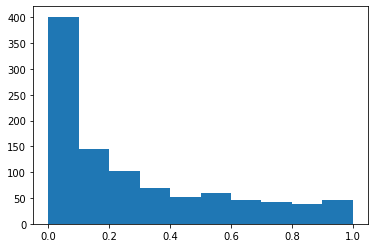

In [270]:
plt.hist(p_value_list)

In [247]:
stats.ttest_ind(dataset_a_bootstrap[idx], dataset_b_bootstrap[idx])[1]

0.4269420211121403

In [237]:
B = 1000
p_val_list = []
for _ in range(B): 
    a = np.random.normal(loc=0, scale=1, size=1000)
    b = np.random.normal(loc=10000, scale=1, size=1000)
    p_val = _calculate_t_stat(a,b)
    p_val_list.append(p_val)

(array([  3.,  14.,  43., 139., 215., 283., 197.,  71.,  29.,   6.]),
 array([-236936.116863  , -234403.85109384, -231871.58532468,
        -229339.31955552, -226807.05378636, -224274.7880172 ,
        -221742.52224804, -219210.25647888, -216677.99070972,
        -214145.72494056, -211613.4591714 ]),
 <a list of 10 Patch objects>)

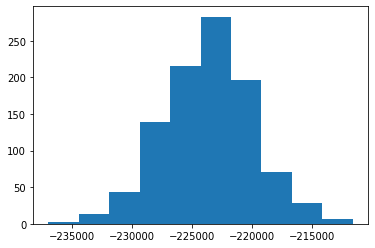

In [238]:
plt.hist(p_val_list)

# ====================

__Вопрос__

Вспомним формулу доверительного интервала для среднего нормально распределённой случайной величины с дисперсией $\sigma^2$

$\bar{X}_n\pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$
 

При $\sigma=1$ какой нужен объём выборки, чтобы на уровне доверия 95% оценить среднее с точностью $\pm0.1$?

In [501]:
n_samples = int((stats.norm.ppf(1-0.05/2) / 0.1)**2)
print(n_samples)

384


# Доверительные интервалы на основе bootstrap

Компания ILEC ремонтирует телекоммуникационного оборудования как свои объекты, так и объекты других кампаний. При этом в случаях, когда время ремонта оборудования для клиентов других компаний существенно выше, чем для собственных, кампания может быть оштрафована.

In [537]:
data = pd.read_csv('verizon.txt', sep='\t')
data.head()

,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


In [538]:
data.Group.value_counts()

ILEC    1664
CLEC      23
Name: Group, dtype: int64

Мы видим что в основном идет ремонт только своео оборудования. Оценим медианы времени работы

In [539]:
ilec_time = data[data.Group == 'ILEC'].Time.values
clec_time = data[data.Group == 'CLEC'].Time.values
print("difference between medians:", np.median(clec_time) - np.median(ilec_time))

difference between medians: 10.74


Непонятно, значима ли эта разница. Поэтому воспользуемся бутспрепом

In [540]:
n_bootstrapp = 1000
alpha = 0.05
bootstrapped_ilec_time = np.random.choice(ilec_time, (n_bootstrapp, len(ilec_time)))
bootstrapped_clec_time = np.random.choice(clec_time, (n_bootstrapp, len(clec_time)))
median_ilec_times = np.median(bootstrapped_ilec_time, axis=1)
median_clec_times = np.median(bootstrapped_clec_time, axis=1)

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(median_ilec_times, median_clec_times)))
left, right = np.percentile(delta_median_scores, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
print("95% confidence interval for the difference between medians",  left, right)

95% confidence interval for the difference between medians 1.9248750000000003 16.650250000000003


Как видим медиана значимо отличается, значит действительно компания дает предпочтения своим клиентам

# Биномиальный критерий для доли
В пятилетнем рандомизированном исследовании Гарвардской медицинской школы 11037 испытуемых через день принимали аспирин, а ещё 11034 — плацебо. Исследование было слепым, то есть, испытуемые не знали, что именно они принимают.

За 5 лет инфаркт случился у 104 испытуемых, принимавших аспирин, и у 189 принимавших плацебо. 

Оцените, насколько вероятность инфаркта снижается при приёме аспирина.

In [541]:
n_samples_1 = 11037
n_samples_2 = 11034
n_success_1 = 104
n_success_2 = 189
p1 = n_success_1 / n_samples_1 
p2 = n_success_2 / n_samples_2
print(np.round(p1 - p2, 4))

-0.0077


In [542]:
p1, p2

(0.009422850412249705, 0.017128874388254486)

Постройте теперь 95% доверительный интервал для снижения вероятности инфаркта при приёме аспирина.

In [544]:
alpha = 0.05
z = stats.norm.ppf(1 - alpha / 2.)
left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n_samples_1 + p2 * (1 - p2)/ n_samples_2)
right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n_samples_1 + p2 * (1 - p2)/ n_samples_2)
print(np.round([left_boundary, right_boundary], 4))

[-0.0107 -0.0047]


In [ ]:
## Можность теста

In [1]:
from statsmodels.stats.power import TTestIndPower

/Users/v.s.dokholyan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [19]:
analysis = TTestIndPower()
effect = 0.02
power = 0.4
alpha=0.05
result = analysis.solve_power(effect,
                              power=power,
                              nobs1=None,
                              ratio=1.0,
                              alpha=alpha,
                              alternative='larger')

In [20]:
result

9682.128490342195

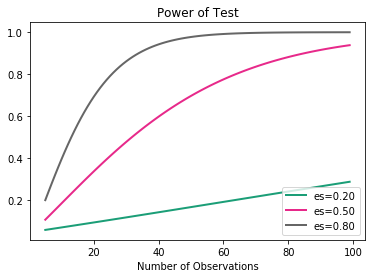

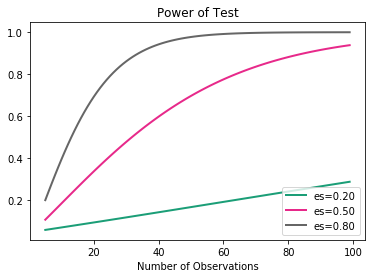

In [23]:
analysis.plot_power(dep_var='nobs', nobs=np.arange(5, 100), effect_size=array([0.2, 0.5, 0.8]))

# Генерация псевдо реальных данные

In [384]:
start_time = datetime(2024, 12, 6, 15, 29, 43, 79060)
value = complicated_expon_generator(size_bounds=[800, 1200])

group = np.random.choice(["A", "B"], size=len(value))
time = [start_time]
for _ in range(len(value) - 1):
    time.append(times[-1] +  timedelta(seconds=np.random.randint(1, 15)))
pseudo_aa_data = pd.DataFrame()
pseudo_aa_data['time'] = time
pseudo_aa_data['value'] = value
pseudo_aa_data['group'] = group
pseudo_aa_data.to_csv('./data/pseudo_aa_data.scv', index=False)



start_time = time[-1]
a_value = complicated_expon_generator(size_bounds=[900, 1100], effect=0)
b_value = complicated_expon_generator(size_bounds=[900, 1100], effect=60)
value = np.array(list(a_value) + list(b_value))
group = ["A"] * len(a_value) + ["B"] * len(b_value)
time = [start_time]
for _ in range(len(group) - 1):
    time.append(times[-1] +  timedelta(seconds=np.random.randint(1, 15)))
time = np.array(time)
np.random.shuffle(time)
pseudo_ab_data = pd.DataFrame()
pseudo_ab_data['time'] = time
pseudo_ab_data['value'] = value
pseudo_ab_data['group'] = group
pseudo_ab_data = pseudo_ab_data.sort_values('time')
pseudo_ab_data.to_csv('./data/pseudo_ab_data.scv', index=False)